In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-08-28 15:07:56 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-08-28 15:07:56 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-08-28 15:07:56 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-08-28 15:08:04 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-28 15:08:04 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-28 15:08:04 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-08-28 15:08:04 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-08-28 15:08:05 src.models WARNING  Qwen/Qwen2.5-72B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-08-28 15:08:05 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-08-28 15:08:05 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-72B-Instruct/resolve/main/config.json HTTP/1.1" 307 0
2025-08-28 15:08:05 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /api/resolve-cache/models/Qwen/Qwen2.5-72B-Instruct/495f39366efef23836d0cfae4fbe635880d2be31/config.json HTTP/1.1" 200 0
2025-08-28 15:08:05 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-72B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 307 0
2025-08-28 15:08:05 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /api/resolve-cache/models/Qwen/Qwen2.5-72B-Instruct/495f39366efef23836d0cfae4fbe635880d2be31/toke

Loading checkpoint shards:   0%|          | 0/37 [00:00<?, ?it/s]

2025-08-28 15:08:52 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-72B-Instruct/resolve/main/generation_config.json HTTP/1.1" 307 0
2025-08-28 15:08:52 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /api/resolve-cache/models/Qwen/Qwen2.5-72B-Instruct/495f39366efef23836d0cfae4fbe635880d2be31/generation_config.json HTTP/1.1" 200 0
2025-08-28 15:08:52 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-72B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-08-28 15:08:52 src.models INFO     loaded model <Qwen/Qwen2.5-72B-Instruct> | size: 138676.078 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [6]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [7]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    obj_idx=2,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample)
print(sample.prompt())

Mango -> Raspberry (2): ['Calculator', 'Potato', 'Raspberry', 'Trumpet', 'Refrigerator', 'Tiara']
# Options: Calculator, Potato, Raspberry, Trumpet, Refrigerator, Tiara.
Which among these objects mentioned above is a fruit?
Answer:


In [8]:
from src.selection.utils import verify_correct_option
# sample.prompt_template = select_prof.prompt_templates[3]
print(f'"{sample.prompt()}"', ">>", sample.obj)

verify_correct_option(
    mt=mt,
    target=sample.obj,
    options=sample.options,
    input=sample.prompt()
)

"# Options: Calculator, Potato, Raspberry, Trumpet, Refrigerator, Tiara.
Which among these objects mentioned above is a fruit?
Answer:" >> Raspberry


(False,
 [PredictedToken(token=' Among', prob=0.412109375, logit=24.125, token_id=21658, metadata=None),
  PredictedToken(token=' The', prob=0.283203125, logit=23.75, token_id=576, metadata=None),
  PredictedToken(token=' Potato', prob=0.1337890625, logit=23.0, token_id=77603, metadata=None),
  PredictedToken(token=' Calculator', prob=0.038330078125, logit=21.75, token_id=36028, metadata=None),
  PredictedToken(token=' Out', prob=0.038330078125, logit=21.75, token_id=4371, metadata=None)],
 OrderedDict([(77603,
               (3,
                PredictedToken(token=' Potato', prob=0.1337890625, logit=23.0, token_id=77603, metadata=None))),
              (36028,
               (5,
                PredictedToken(token=' Calculator', prob=0.038330078125, logit=21.75, token_id=36028, metadata=None))),
              (47565,
               (17,
                PredictedToken(token=' Raspberry', prob=0.000545501708984375, logit=17.5, token_id=47565, metadata=None))),
              (22325,
  

In [9]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


You have set `compile_config`, but we are unable to meet the criteria for compilation. Compilation will be skipped.


" Among the objects you've listed, none of them are fruits. However, if we consider common definitions" >> Raspberry


In [10]:
mt.n_layer, mt.config.num_attention_heads

(80, 64)

In [24]:
llama_70_heads = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]

qwen_72_heads = [
    (62, 1),
    (60, 9),
    (64, 8),
    (62, 0),
    (62, 45),
    (59, 59),
    (71, 28),
    (64, 12),
    (61, 7),
    (64, 13),
    (67, 53),
    (67, 51),
    (54, 44),
    (57, 5),
    (59, 60),
    (71, 25),
    (62, 7),
    (64, 9),
    (62, 23),
    (65, 40),
]


# HEADS = [(35, 19)]


# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]
# HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]

HEADS = qwen_72_heads
# HEADS = llama_70_heads
print(len(HEADS))

20


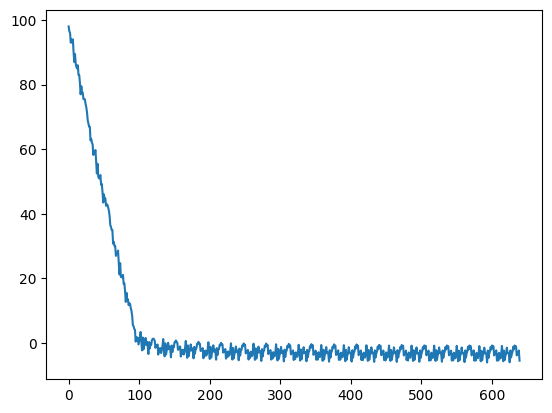

In [27]:
from matplotlib import pyplot as plt
import numpy as np

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_backup_heads",
    mt.name.split("/")[-1],
    f"{select_task.task_name}.npz"
)

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_heads",
#     mt.name.split("/")[-1],
#     # "distinct_options",
#     f"{select_task.task_name}",
#     "epoch_10.npz"
# )

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

66


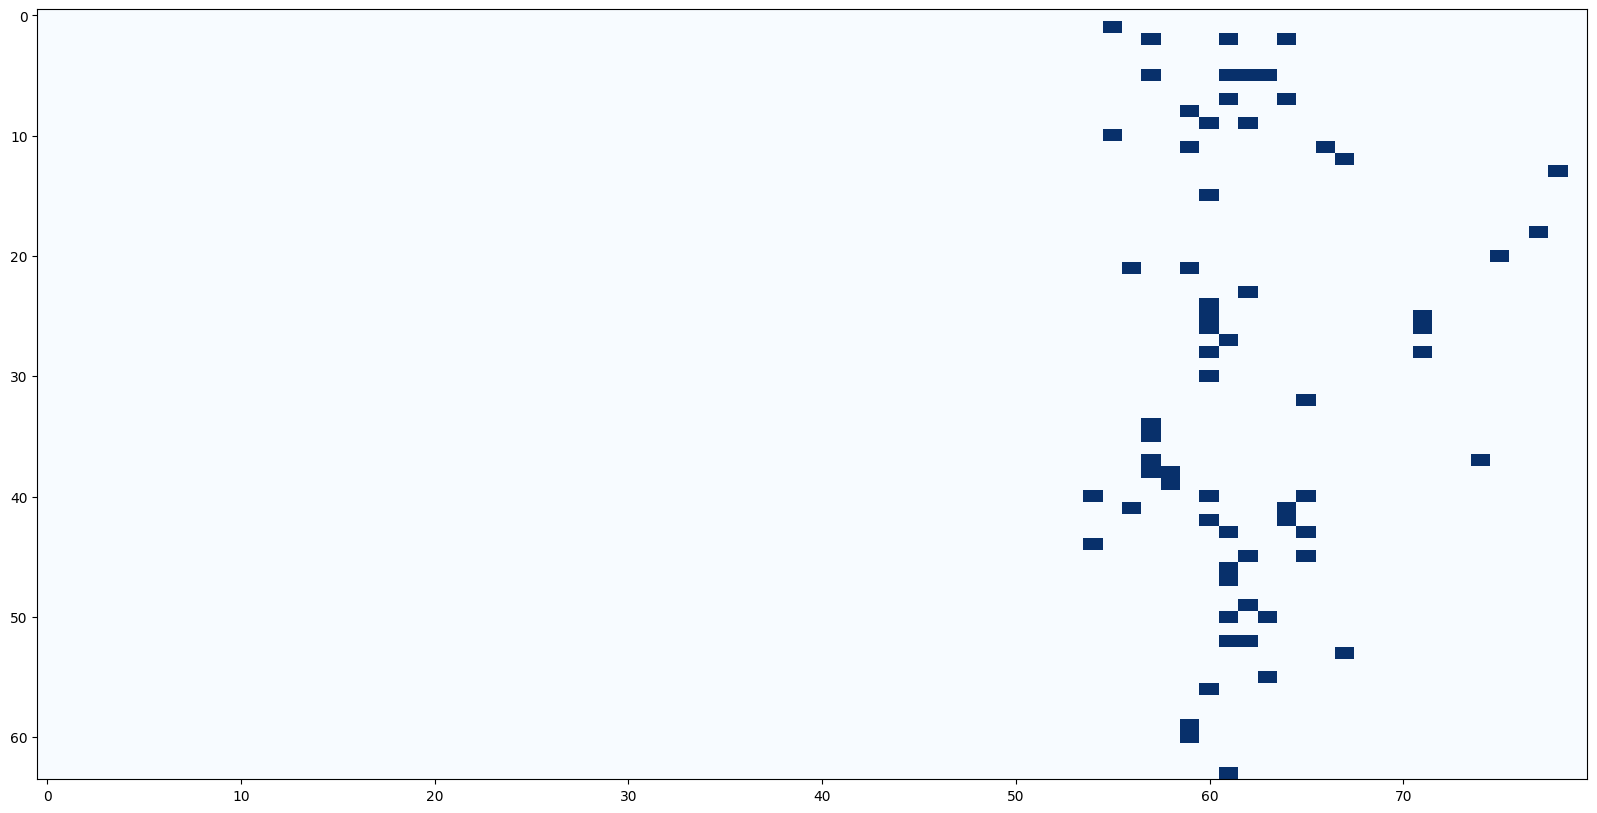

In [29]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
# optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

optimized_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
optimized_heads = [
    (layer_idx, head_idx) for layer_idx, head_idx in optimized_heads
]
print(len(optimized_heads))

HEADS = optimized_heads

# (35, 19) in HEADS, (35, 19) in heads_selected

In [30]:
# from src.tokens import find_token_range, prepare_input

# string = sample.prompt()
# substring = sample.obj

# tokenized_prompt = prepare_input(
#     prompts=string, 
#     tokenizer=mt.tokenizer, 
#     return_offsets_mapping=True,
#     add_bos_token="qwen" in mt.name.lower()
# )
# string = mt.tokenizer.decode(tokenized_prompt.input_ids[0], skip_special_tokens=False)
# offset_mapping = tokenized_prompt.pop("offset_mapping")[0]

# ans_range = find_token_range(
#     string=string,
#     substring=substring,
#     offset_mapping=offset_mapping
# )
# print(f"Answer range: {ans_range}")
# print(f'"{mt.tokenizer.decode(tokenized_prompt.input_ids[0][range(*ans_range)])}"')
# # for idx, (tok, offset_range) in enumerate(zip(tokenized_prompt.input_ids[0], offset_mapping)):
# #     print(f"Token {idx}: \"{mt.tokenizer.decode([tok])}\" -- {offset_range}")

In [31]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    pivot=sample.subj,
    mt=mt,
    # heads=optimized_heads,
    heads = HEADS,
    start_from=1
)

0 patches to ablate possible answer information from options
2025-08-28 15:16:33 src.selection.functional DEBUG    Predictions: ['" Sub"[3719] (p=0.734, logit=26.625)', '" The"[576] (p=0.145, logit=25.000)', '" Among"[21658] (p=0.053, logit=24.000)', '" A"[362] (p=0.017, logit=22.875)', '" \n"[715] (p=0.013, logit=22.625)']
2025-08-28 15:16:33 src.selection.functional INFO     Combined attention matrix for all heads


In [112]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input

######################################################################
N_DISTRACTORS = 5
WINDOW_SPEC = {
    mt.layer_name_format: 1,
    mt.mlp_module_name_format: 9,
    mt.attn_module_name_format: 9,
}
module_name_format = mt.layer_name_format
# module_name_format = mt.mlp_module_name_format
# module_name_format = mt.attn_module_name_format

######################################################################


@torch.inference_mode()
def get_counterfactual_samples_within_task(
    task: SelectOneTask | SelectOrderTask = select_task,
    patch_category: str | None = None,
    clean_category: str | None = None,
    shuffle_clean_options: bool = False,
    prompt_template_idx=2,
    option_style="numbered",
    filter_by_lm_prediction: bool = True,
    distinct_options: bool = False,
    n_distractors: int = N_DISTRACTORS,
):
    categories = list(task.category_wise_examples.keys())
    if patch_category is None:
        patch_category = random.choice(categories)

    patch_subj, patch_obj = random.sample(
        task.category_wise_examples[patch_category], 2
    )
    logger.info(
        f"Patch category: {patch_category}, subject: {patch_subj}, object: {patch_obj}"
    )

    if clean_category is None:
        clean_category = random.choice(list(set(categories) - {patch_category}))

    clean_options = task.category_wise_examples[clean_category]
    random.shuffle(clean_options)

    clean_subj, clean_obj = random.sample(
        (
            KeyedSet(clean_options, mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)
        ).values,
        2,
    )
    logger.info(
        f"Clean category: {clean_category}, subject: {clean_subj}, object: {clean_obj}"
    )

    if distinct_options is False:
        patch_type_obj = patch_obj
        clean_type_obj = clean_obj
    else:
        patch_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[patch_category], mt.tokenizer)
                - KeyedSet([patch_obj], mt.tokenizer)
            ).values
        )
        clean_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[clean_category], mt.tokenizer)
                - KeyedSet([clean_obj], mt.tokenizer)
            ).values
        )

    patch_must_have_options = [patch_obj, clean_type_obj]
    clean_must_have_options = [clean_obj, patch_type_obj]

    logger.info(f"{patch_must_have_options=}")
    logger.info(f"{clean_must_have_options=}")
    logger.info(f"{clean_type_obj=}")
    logger.info(f"{patch_type_obj=}")

    patch_distractors = []
    other_categories = random.sample(
        list(set(categories) - {patch_category, clean_category}),
        k=n_distractors - (len(patch_must_have_options)) + 1,
    )

    for other_category in other_categories:
        other_examples = task.category_wise_examples[other_category]
        random.shuffle(other_examples)
        other_examples = KeyedSet(other_examples, mt.tokenizer)
        patch_distractors.append(
            random.choice(
                (
                    other_examples
                    - KeyedSet(
                        patch_must_have_options + patch_distractors,
                        tokenizer=mt.tokenizer,
                    )
                ).values
            )
        )

    patch_options = patch_must_have_options + patch_distractors
    random.shuffle(patch_options)
    patch_obj_idx = patch_options.index(patch_obj)
    logger.info(f"{patch_obj_idx=} | {patch_options}")

    if distinct_options is not True:
        clean_options = copy.deepcopy(patch_options)
        if shuffle_clean_options:
            # Useful for the pointer experiments
            while (
                clean_options.index(clean_obj) == patch_obj_idx
                or clean_options.index(patch_type_obj) == patch_obj_idx
            ):
                random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    else:
        other_categories = random.sample(
            list(set(categories) - {patch_category, clean_category}),
            k=n_distractors - (len(clean_must_have_options)) + 1,
        )
        clean_distractors = []
        for other_category in other_categories:
            other_examples = task.category_wise_examples[other_category]
            random.shuffle(other_examples)
            other_examples = KeyedSet(other_examples, mt.tokenizer)
            clean_distractors.append(
                random.choice(
                    (
                        other_examples
                        - KeyedSet(
                            clean_must_have_options + clean_distractors,
                            tokenizer=mt.tokenizer,
                        )
                    ).values
                )
            )
        clean_options = clean_must_have_options + clean_distractors
        random.shuffle(clean_options)
        while clean_options.index(clean_obj) == patch_obj_idx or clean_options.index(patch_type_obj) == patch_obj_idx:
            random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    logger.info(f"{clean_obj_idx=} | {clean_options}")

    kwargs = dict(
        prompt_template=task.prompt_templates[prompt_template_idx],
        default_option_style=option_style,
    )
    print(f"{type(task)=}")
    if isinstance(task, SelectOrderTask):
        patch_metadata = {
            "track_type_obj_idx": clean_obj_idx,
            "track_type_obj": patch_options[clean_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                patch_options[clean_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_type_obj_idx": patch_obj_idx,
            "track_type_obj": clean_options[patch_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                clean_options[patch_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
    elif isinstance(task, SelectOneTask):
        patch_metadata = {
            "track_category": clean_category,
            "track_type_obj": clean_type_obj,
            "track_type_obj_idx": patch_options.index(clean_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                clean_type_obj, mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_category": patch_category,
            "track_type_obj": patch_type_obj,
            "track_type_obj_idx": clean_options.index(patch_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                patch_type_obj, mt.tokenizer, prefix=" "
            ),
        }
    else:
        raise NotImplementedError(f"Unsupported task type: {type(task)}")

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        answer=patch_obj,
        obj_idx=patch_obj_idx,
        ans_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        category=patch_category,
        metadata=patch_metadata,
        **kwargs,
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        answer=clean_obj,
        obj_idx=clean_obj_idx,
        ans_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        category=clean_category,
        metadata=clean_metadata,
        **kwargs,
    )

    if "qwen" in mt.name.lower():
        # for attention sink
        patch_sample.prompt_template = "# " + patch_sample.prompt_template
        clean_sample.prompt_template = "# " + clean_sample.prompt_template  

    if filter_by_lm_prediction:
        test_samples = [patch_sample, clean_sample]
        if distinct_options is True:
            clean_sample_2 = copy.deepcopy(patch_sample)
            clean_sample_2.options = clean_options
            clean_sample_2.obj = clean_sample.metadata["track_type_obj"]
            clean_sample_2.obj_idx = clean_sample.metadata["track_type_obj_idx"]
            clean_sample_2.ans_token_id = clean_sample.metadata[
                "track_type_obj_token_id"
            ]
            test_samples.append(clean_sample_2)

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())
            is_correct, predictions, track_options = verify_correct_option(
                mt=mt, target=sample.obj, options=sample.options, input=tokenized
            )
            sample.metadata["tokenized"] = tokenized.data
            logger.info(sample.prompt())
            logger.info(
                f"{sample.subj} | {sample.category} -> {sample.obj} | pred={[str(p) for p in predictions]}"
            )
            if not is_correct:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                return get_counterfactual_samples_within_task(
                    task=task,
                    patch_category=patch_category,
                    clean_category=clean_category,
                    shuffle_clean_options=shuffle_clean_options,
                    prompt_template_idx=prompt_template_idx,
                    option_style=option_style,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    distinct_options=distinct_options,
                    n_distractors=n_distractors,
                )
            sample.prediction = predictions

    return patch_sample, clean_sample

In [113]:
type(select_task)

src.selection.data.SelectOneTask

In [122]:
patch_sample, clean_sample = get_counterfactual_samples_within_task(
    # patch_category="politician",
    # clean_category="actor",
    task=select_task,
    patch_category="fruit",
    clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    option_style=OPTION_STYLE,
    distinct_options=True,
    n_distractors=5,
)

# patch_sample.default_option_style = "single_line"
# clean_sample.default_option_style = "numbered"

clean_sample.metadata

2025-08-28 15:40:48 __main__ INFO     Patch category: fruit, subject: Pineapple, object: Kiwi
2025-08-28 15:40:48 __main__ INFO     Clean category: vehicle, subject: Tractor, object: Car
2025-08-28 15:40:48 __main__ INFO     patch_must_have_options=['Kiwi', 'Bus']
2025-08-28 15:40:48 __main__ INFO     clean_must_have_options=['Car', 'Raspberry']
2025-08-28 15:40:48 __main__ INFO     clean_type_obj='Bus'
2025-08-28 15:40:48 __main__ INFO     patch_type_obj='Raspberry'
2025-08-28 15:40:48 __main__ INFO     patch_obj_idx=4 | ['Sheep', 'Bat', 'Bus', 'Trumpet', 'Kiwi', 'Air fryer']
2025-08-28 15:40:48 __main__ INFO     clean_obj_idx=5 | ['Cello', 'Library', 'Football', 'Raspberry', 'Locket', 'Car']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-28 15:40:48 __main__ INFO     # Options: Sheep, Bat, Bus, Trumpet, Kiwi, Air fryer.
Which among these objects mentioned above is a fruit?
Answer:
2025-08-28 15:40:48 __main__ INFO     Pineapple | fruit -> Kiwi | pred=['" None"[2240] (p

{'track_category': 'fruit',
 'track_type_obj': 'Raspberry',
 'track_type_obj_idx': 3,
 'track_type_obj_token_id': 47565,
 'tokenized': {'input_ids': tensor([[    2, 14566,    25,   356,  4791,    11, 11635,    11, 20761,    11,
           47565,    11,   444,  4537,    11,  3261,   624, 23085,  4221,  1493,
            6171,  9733,  3403,   374,   264,  7310,  5267, 16141,    25]],
         device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1]], device='cuda:0')}}

In [123]:
# order_sample_1 = SelectionSample(
#     subj="random",
#     category="test_order",
#     options=["Bike", "Apple", "Bed", "Dog", "Monitor", "Theater"],
#     obj="Apple",
#     obj_idx=1,
#     prompt_template="<_options_>\nWhat is the third item in the list?\nAnswer:",
#     answer="Apple",
# )

# order_sample_2 = SelectionSample(
#     subj="random",
#     category="test_order",
#     options=["Cat", "Chair", "Bus", "Phone", "Library", "Orange"],
#     obj="Phone",
#     obj_idx=3,
#     prompt_template="<_options_>\nWhat is the fifth item in the list?\nAnswer:",
#     answer="Phone",
# )
len(HEADS)

66

In [124]:
from src.functional import generate_with_patch
from src.selection.functional import verify_head_patterns

# patch_sample.options[patch_sample.obj_idx] = "Screw"
# patch_sample.options[patch_sample.obj_idx] = patch_sample.obj

gold_sample = copy.deepcopy(patch_sample)
gold_sample.options = clean_sample.options

for sample in [patch_sample, clean_sample, gold_sample]:
# for sample in [order_sample_1, order_sample_2]:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=qwen_72_heads,
        # heads=[(layer_idx, head_idx)],
        # generate_full_answer=True,
        query_index=-1
    )

# Options: Sheep, Bat, Bus, Trumpet, Kiwi, Air fryer.
Which among these objects mentioned above is a fruit?
Answer: >> Kiwi
0 patches to ablate possible answer information from options
2025-08-28 15:40:51 src.selection.functional DEBUG    Predictions: ['" None"[2240] (p=0.828, logit=24.875)', '" Ki"[29458] (p=0.077, logit=22.500)', '" Among"[21658] (p=0.036, logit=21.750)', '" \n"[715] (p=0.019, logit=21.125)', '" The"[576] (p=0.015, logit=20.875)']
2025-08-28 15:40:51 src.selection.functional INFO     Combined attention matrix for all heads


# Options: Cello, Library, Football, Raspberry, Locket, Car.
Which among these objects mentioned above is a vehicle?
Answer: >> Car
0 patches to ablate possible answer information from options
2025-08-28 15:40:51 src.selection.functional DEBUG    Predictions: ['" Car"[3261] (p=0.879, logit=29.500)', '" The"[576] (p=0.072, logit=27.000)', '" \n"[715] (p=0.014, logit=25.375)', '" A"[362] (p=0.014, logit=25.375)', '" To"[2014] (p=0.005, logit=24.375)']
2025-08-28 15:40:51 src.selection.functional INFO     Combined attention matrix for all heads


# Options: Cello, Library, Football, Raspberry, Locket, Car.
Which among these objects mentioned above is a fruit?
Answer: >> Kiwi
0 patches to ablate possible answer information from options
2025-08-28 15:40:52 src.selection.functional DEBUG    Predictions: ['" Raspberry"[47565] (p=0.852, logit=26.500)', '" The"[576] (p=0.090, logit=24.250)', '" Among"[21658] (p=0.026, logit=23.000)', '" \n"[715] (p=0.014, logit=22.375)', '" To"[2014] (p=0.007, logit=21.750)']
2025-08-28 15:40:52 src.selection.functional INFO     Combined attention matrix for all heads


In [117]:
clean_sample.metadata

{'track_category': 'fruit',
 'track_type_obj': 'Apple',
 'track_type_obj_idx': 1,
 'track_type_obj_token_id': 8162,
 'tokenized': {'input_ids': tensor([[    2, 14566,    25, 45406,    11,  8162,    11, 37830,    11, 69010,
              11, 22325,  5059,    11, 98931,   624, 23085,  4221,  1493,  6171,
            9733,  3403,   374,   264,  7310,  5267, 16141,    25]],
         device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1]], device='cuda:0')}}

## Testing patching the query projection of a single head

In [125]:
from src.selection.functional import cache_q_projections
from src.functional import patch_with_baukit, PatchSpec

# layer_idx, head_idx = 35, 19
layer_idx, head_idx = 62, 1

print(layer_idx, head_idx)
patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)
clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

# query_locations = [(layer_idx, head_idx, -1)]
query_locations = [(layer_idx, head_idx, -idx) for idx in range(1, 2)]
query_locations = [(l_idx, h_idx, -1) for l_idx, h_idx in qwen_72_heads]
query_locations = sorted(query_locations, key=lambda x: (x[0], x[1]))

q_states = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    query_locations=query_locations
)
q_patches = []
for l_idx, h_idx, t_idx in query_locations:
    q_patches.append(PatchSpec(
        location=(
            mt.attn_module_name_format.format(l_idx)+".q_proj",
            h_idx,
            t_idx
        ),
        patch=q_states[(l_idx, h_idx, t_idx)].squeeze()
    ))

test_inplace_swap = verify_head_patterns(
    prompt=patch_sample.prompt(),
    mt=mt,
    # heads=[(layer_idx, head_idx)],
    heads=qwen_72_heads,
    tokenized_prompt=patch_tokenized,
    query_patches=q_patches
)

test_predicate_swap = verify_head_patterns(
    prompt=clean_sample.prompt(),
    mt=mt,
    # heads=[(layer_idx, head_idx)],
    heads=qwen_72_heads,
    tokenized_prompt=clean_tokenized,
    query_patches=q_patches
)

62 1
20 patches to ablate possible answer information from options
2025-08-28 15:40:58 src.selection.functional DEBUG    Predictions: ['" None"[2240] (p=0.828, logit=24.875)', '" Ki"[29458] (p=0.077, logit=22.500)', '" Among"[21658] (p=0.036, logit=21.750)', '" \n"[715] (p=0.019, logit=21.125)', '" The"[576] (p=0.015, logit=20.875)']
2025-08-28 15:40:58 src.selection.functional INFO     Combined attention matrix for all heads


20 patches to ablate possible answer information from options
2025-08-28 15:40:58 src.selection.functional DEBUG    Predictions: ['" Car"[3261] (p=0.836, logit=26.750)', '" The"[576] (p=0.100, logit=24.625)', '" \n"[715] (p=0.029, logit=23.375)', '" \n\n"[4710] (p=0.009, logit=22.250)', '" To"[2014] (p=0.006, logit=21.875)']
2025-08-28 15:40:58 src.selection.functional INFO     Combined attention matrix for all heads


In [19]:
import baukit
from src.functional import get_module_nnsight, PatchSpec
from src.hooking.llama_attention import LlamaAttentionPatcher
import types
from typing import Literal
from src.tokens import prepare_input


def set_attn_implementation(mt, attn_implementation: Literal["sdpa", "eager"]):
    mt.config._attn_implementation = attn_implementation
    for layer_idx in range(mt.config.num_hidden_layers):
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.config._attn_implementation = attn_implementation


###################################################################################
batch_size = 1  # tokenized.input_ids.shape[0]
n_heads = mt.config.num_attention_heads
head_dim = mt.n_embd // n_heads
query_idx = -1 # almost always the last token
###################################################################################

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layer_idx, head_idx = HEADS[0]

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(block_name=attn_block_name),
    attn_block,
)

patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)
patch_seq_len = patch_tokenized.input_ids.shape[1]
input_ln = mt.layer_name_format.format(layer_idx) + ".input_layernorm"

with mt.trace(patch_tokenized) as trace:
    ln_module = get_module_nnsight(mt, input_ln)
    patch_ln = ln_module.output.save()

    q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
    q_proj_module = get_module_nnsight(mt, q_proj_name)
    patch_q_proj = q_proj_module.output.view(batch_size, patch_seq_len, n_heads, head_dim).transpose(1, 2).save()
    # patch_q_proj = PatchSpec(
    #     location=(q_proj_name + f".{head_idx}", -1),
    #     patch=patch_q_proj[:, head_idx, query_idx, :].squeeze().save()
    # )

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
clean_seq_len = clean_tokenized.input_ids.shape[1]
with mt.trace(clean_tokenized) as trace:
    ln_module = get_module_nnsight(mt, input_ln)
    clean_ln = ln_module.output.save()

    q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
    q_proj_module = get_module_nnsight(mt, q_proj_name)
    clean_q_proj = q_proj_module.output.view(batch_size, clean_seq_len, n_heads, head_dim).transpose(1, 2).save()
    # clean_q_proj = PatchSpec(
    #     location=(q_proj_name + f".{head_idx}", -1),
    #     patch=clean_q_proj[:, head_idx, query_idx, :].squeeze().save()
    # )

mt.reset_forward()
set_attn_implementation(mt, "eager")

patch_q_proj.shape, clean_q_proj.shape, patch_ln.shape, clean_ln.shape

(torch.Size([1, 64, 31, 128]),
 torch.Size([1, 64, 29, 128]),
 torch.Size([1, 31, 8192]),
 torch.Size([1, 29, 8192]))

In [21]:
from src.attention import visualize_attn_matrix
from src.functional import get_hs, interpret_logits

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layer_idx, head_idx = 35, 19
# layer_idx, head_idx = 62, 1

attn_matrices = {layer_idx: {}}

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name=attn_block_name,
        save_attn_for=[head_idx],
        store_attn_matrices=attn_matrices[layer_idx],
    ),
    attn_block,
)

logit_location = (mt.lm_head_name, -1)
logits = get_hs(
    mt = mt,
    input = clean_tokenized,
    locations = [logit_location],
    return_dict=False
).squeeze()  # (seq_len, vocab_size)

mt.reset_forward()
set_attn_implementation(mt, "eager")

head_matrix = attn_matrices[layer_idx][head_idx].squeeze().to(torch.float32).cpu().numpy()

visualize_attn_matrix(
    attn_matrix=head_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=logits,
    interested_tokens=[clean_sample.metadata["track_type_obj_token_id"]],
)

([PredictedToken(token=' Amb', prob=0.67578125, logit=22.125, token_id=20423, metadata=None),
  PredictedToken(token=' An', prob=0.1708984375, logit=20.75, token_id=1556, metadata=None),
  PredictedToken(token=' The', prob=0.0625, logit=19.75, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.055419921875, logit=19.625, token_id=22395, metadata=None),
  PredictedToken(token=' Only', prob=0.004547119140625, logit=17.125, token_id=8442, metadata=None)],
 OrderedDict([(45805,
               (237,
                PredictedToken(token=' Cherry', prob=3.4421682357788086e-06, logit=9.9375, token_id=45805, metadata=None)))]))

35 19
1 patches to ablate possible answer information from options
2025-08-28 15:04:31 src.selection.functional DEBUG    Predictions: ['" Amb"[20423] (p=0.691, logit=22.000)', '" An"[1556] (p=0.137, logit=20.375)', '" The"[578] (p=0.073, logit=19.750)', '" Among"[22395] (p=0.057, logit=19.500)', '" Only"[8442] (p=0.005, logit=17.125)']
2025-08-28 15:04:31 src.selection.functional INFO     Combined attention matrix for all heads


{'predictions': [PredictedToken(token=' Amb', prob=0.69140625, logit=22.0, token_id=20423, metadata=None),
  PredictedToken(token=' An', prob=0.13671875, logit=20.375, token_id=1556, metadata=None),
  PredictedToken(token=' The', prob=0.0732421875, logit=19.75, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.056884765625, logit=19.5, token_id=22395, metadata=None),
  PredictedToken(token=' Only', prob=0.005279541015625, logit=17.125, token_id=8442, metadata=None)],
 'logits': tensor([-0.0486,  2.5312,  1.9062,  ...,  0.3945,  0.3945,  0.3945],
        dtype=torch.bfloat16),
 'attn_matrices': AttentionInformation(tokenized_prompt=['<|begin_of_text|>', 'Options', ':', ' Amb', 'ulance', ',', ' Marker', ',', ' Cherry', ',', ' Pendant', ',', ' Pressure', ' cooker', ',', ' Hat', '.\n', 'Which', ' among', ' these', ' objects', ' mentioned', ' above', ' is', ' a', ' vehicle', '?\n', 'Answer', ':'], attention_matrices=array([[[[1.00000000e+00, 0.00000000e+00, 0.00000000e+0

In [44]:
patch_tokenized

{'input_ids': tensor([[128000,   3883,     25,   6690,  53646,    261,     11,  70762,     11,
          47033,     11,  47589,     11,  48035,  38880,     11,   8868,  15717,
            627,  23956,   4315,   1521,   6302,   9932,   3485,    374,    264,
          14098,   5380,  16533,     25]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [22]:
# type(mt._model), query_idx
head_idx, query_idx, patch_q_proj[:, head_idx, query_idx, :].shape

(19, -1, torch.Size([1, 128]))

In [23]:
from src.attention import visualize_attn_matrix

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

attn_matrices = {layer_idx: {}}

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name=attn_block_name,
        save_attn_for=[head_idx],
        store_attn_matrices=attn_matrices[layer_idx],
        query_patches=[(head_idx, query_idx, patch_q_proj[:, head_idx, query_idx, :].squeeze())],
    ),
    attn_block,
)

logit_location = (mt.lm_head_name, -1)
patch_logits = get_hs(
    mt = mt,
    # input = clean_tokenized,
    input=patch_tokenized,
    locations = [logit_location],
    return_dict=False
).squeeze()  # (seq_len, vocab_size)

mt.reset_forward()
set_attn_implementation(mt, "eager")

head_matrix = attn_matrices[layer_idx][head_idx].squeeze().to(torch.float32).cpu().numpy()

visualize_attn_matrix(
    attn_matrix=head_matrix,
    # tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    tokens=[mt.tokenizer.decode(t) for t in patch_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=patch_logits,
    interested_tokens=[clean_sample.metadata["track_type_obj_token_id"]],
)

([PredictedToken(token=' Blue', prob=0.765625, logit=22.625, token_id=8868, metadata=None),
  PredictedToken(token=' The', prob=0.150390625, logit=21.0, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.03369140625, logit=19.5, token_id=22395, metadata=None),
  PredictedToken(token=' A', prob=0.0296630859375, logit=19.375, token_id=362, metadata=None),
  PredictedToken(token=' ', prob=0.00189208984375, logit=16.625, token_id=220, metadata=None)],
 OrderedDict([(45805,
               (162,
                PredictedToken(token=' Cherry', prob=4.708766937255859e-06, logit=10.625, token_id=45805, metadata=None)))]))

In [36]:
torch.allclose(patch_logits, logits, atol = 1e-3)

False

In [37]:
torch.allclose(
    patch_q_proj[:, head_idx, query_idx, :], 
    clean_q_proj[:, head_idx, query_idx, :],
    atol=1e-3
)

False

In [27]:
# torch.allclose(
#     patch_ln[:, query_idx, :], 
#     clean_ln[:, query_idx, :],
#     atol=1e-3
# )

In [28]:
# patch_ln[:, query_idx, :], clean_ln[:, query_idx, :]

In [29]:
# # manual calculation
# attn_module = baukit.get_module(mt._model, mt.attn_module_name_format.format(layer_idx))
# patch_q_proj_manual = attn_module.q_proj(patch_ln)
# clean_q_proj_manual = attn_module.q_proj(clean_ln)

# print(patch_q_proj_manual.shape, clean_q_proj_manual.shape)
# print(torch.allclose(
#     patch_q_proj_manual[:, query_idx, :], 
#     clean_q_proj_manual[:, query_idx, :],
#     atol=1e-3
# ))

# patch_q_proj_manual = patch_q_proj_manual.reshape(batch_size, patch_seq_len, n_heads, head_dim).transpose(1, 2)
# clean_q_proj_manual = clean_q_proj_manual.reshape(batch_size, clean_seq_len, n_heads, head_dim).transpose(1, 2)
# print(patch_q_proj_manual.shape, clean_q_proj_manual.shape)

# for idx in range(n_heads):
#     print(head_idx, torch.allclose(
#         patch_q_proj_manual[:, idx, query_idx, :], 
#         clean_q_proj_manual[:, idx, query_idx, :],
#         atol=1e-3
#     ))

In [30]:
# torch.allclose(
#     patch_q_proj_manual[:, head_idx, query_idx, :], 
#     patch_q_proj[:, head_idx, query_idx, :],
#     atol=1e-3
# )

In [31]:
replace_q_proj = clean_q_proj.clone()
replace_q_proj[:, head_idx, query_idx, :] = patch_q_proj[:, head_idx, query_idx, :]

print(torch.allclose(
        replace_q_proj[:, head_idx, query_idx, :],
        clean_q_proj[:, head_idx, query_idx, :],
        atol=1e-3
    )
)
print(replace_q_proj.shape)

replace_q_proj = replace_q_proj.transpose(1, 2).reshape(batch_size, clean_seq_len, -1)

rep_patch = PatchSpec(
    location=(q_proj_name, -1),
    patch=replace_q_proj[:, -1, :].squeeze(),
)

ln_patch = PatchSpec(
    location=(input_ln, -1),
    patch=patch_ln[:, query_idx, :].squeeze(),
)

head_q_patch = PatchSpec(
    location=(q_proj_name, head_idx, -1),
    patch=patch_q_proj[:, head_idx, query_idx, :].squeeze(),
)

head_q_patch.location, rep_patch.location

False
torch.Size([1, 64, 29, 128])


NameError: name 'q_proj_name' is not defined

In [37]:
# clean_q_proj_rs = clean_q_proj.view(batch_size, clean_seq_len, -1)
# patch_q_proj_rs = patch_q_proj.view(batch_size, clean_seq_len, -1)
# clean_q_proj_rs[:, -1, :].shape, patch_q_proj_rs[:, -1, :].shape

In [38]:
# torch.allclose(
#     replace_q_proj[:, -1, :].squeeze(), 
#     # patch_q_proj_rs[:, -1, :].squeeze(),
#     clean_q_proj_rs[:, -1, :].squeeze(), 
#     atol=1e-3
# )

In [32]:
patch_q_proj.shape, clean_q_proj.shape
# torch.allclose(patch_q_proj.patch, clean_q_proj.patch)

(torch.Size([1, 64, 31, 128]), torch.Size([1, 64, 29, 128]))

In [33]:
clean_sample.metadata

{'track_category': 'fruit',
 'track_type_obj': 'Cherry',
 'track_type_obj_idx': 2,
 'track_type_obj_token_id': 45805,
 'tokenized': {'input_ids': tensor([[128000,   3883,     25,  20423,  41932,     11,  40975,     11,  45805,
               11,  81501,     11,  40090,  63183,     11,  22050,    627,  23956,
             4315,   1521,   6302,   9932,   3485,    374,    264,   7458,   5380,
            16533,     25]], device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1]], device='cuda:0')}}

In [34]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import interpret_logits

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

attn_info = get_attention_matrices(
    input=clean_tokenized,
    mt=mt,
)

attn_matrix = attn_info.attention_matrices[layer_idx, head_idx].squeeze()
visualize_attn_matrix(
    attn_matrix=attn_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=attn_info.logits,
    interested_tokens=[clean_sample.ans_token_id, clean_sample.metadata["track_type_obj_token_id"]]
)

([PredictedToken(token=' Amb', prob=0.67578125, logit=22.125, token_id=20423, metadata=None),
  PredictedToken(token=' An', prob=0.1708984375, logit=20.75, token_id=1556, metadata=None),
  PredictedToken(token=' The', prob=0.06298828125, logit=19.75, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.055419921875, logit=19.625, token_id=22395, metadata=None),
  PredictedToken(token=' Only', prob=0.004547119140625, logit=17.125, token_id=8442, metadata=None)],
 OrderedDict([(20423,
               (1,
                PredictedToken(token=' Amb', prob=0.67578125, logit=22.125, token_id=20423, metadata=None))),
              (45805,
               (235,
                PredictedToken(token=' Cherry', prob=3.4421682357788086e-06, logit=9.9375, token_id=45805, metadata=None)))]))

In [35]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import patch_with_nnsight, patch_with_baukit

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

patched_attn_info = get_attention_matrices(
    input=clean_tokenized,
    mt=mt,
    # patches=[ln_patch],
    patches = [head_q_patch],
    # patches = [rep_patch],
    # patch_interface=patch_with_nnsight
    patch_interface=patch_with_baukit
)

patched_attn_matrix = patched_attn_info.attention_matrices[layer_idx, head_idx].squeeze()
visualize_attn_matrix(
    attn_matrix=patched_attn_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=patched_attn_info.logits,
    interested_tokens=[clean_sample.ans_token_id, clean_sample.metadata["track_type_obj_token_id"]]
)

NameError: name 'head_q_patch' is not defined

## Patching a bunch of heads

### Loading the Heads

#### Attention Behavior

In [32]:
from scripts.locate_via_attention_behavior import SelectionSampleAttn
attn_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/attention_patterns/select_one",
    mt.name.split("/")[-1],
    "objects"
)
files = sorted(os.listdir(attn_path))
print(files)

#######################################################################
# LIMIT = 256
LIMIT = len(files)
#######################################################################

selection_attns = []

for npz_file in files[:LIMIT]:
    if not npz_file.endswith(".npz"):
        continue

    npz_path = os.path.join(attn_path, npz_file)
    selection_attns.append(SelectionSampleAttn.from_npz(npz_path))
    if len(selection_attns) % 128 == 0:
        print(f"Loaded {len(selection_attns)}/{LIMIT} files")

len(selection_attns)

['sample_0000.npz', 'sample_0001.npz', 'sample_0002.npz', 'sample_0003.npz', 'sample_0004.npz', 'sample_0005.npz', 'sample_0006.npz', 'sample_0007.npz', 'sample_0008.npz', 'sample_0009.npz', 'sample_0010.npz', 'sample_0011.npz', 'sample_0012.npz', 'sample_0013.npz', 'sample_0014.npz', 'sample_0015.npz', 'sample_0016.npz', 'sample_0017.npz', 'sample_0018.npz', 'sample_0019.npz', 'sample_0020.npz', 'sample_0021.npz', 'sample_0022.npz', 'sample_0023.npz', 'sample_0024.npz', 'sample_0025.npz', 'sample_0026.npz', 'sample_0027.npz', 'sample_0028.npz', 'sample_0029.npz', 'sample_0030.npz', 'sample_0031.npz', 'sample_0032.npz', 'sample_0033.npz', 'sample_0034.npz', 'sample_0035.npz', 'sample_0036.npz', 'sample_0037.npz', 'sample_0038.npz', 'sample_0039.npz', 'sample_0040.npz', 'sample_0041.npz', 'sample_0042.npz', 'sample_0043.npz', 'sample_0044.npz', 'sample_0045.npz', 'sample_0046.npz', 'sample_0047.npz', 'sample_0048.npz', 'sample_0049.npz', 'sample_0050.npz', 'sample_0051.npz', 'sample_005

2048

In [33]:
from src.attention import visualize_attn_matrix

sample_idx = 145
# layer_idx = 39
# head_idx = 40
layer_idx = 54
head_idx = 44

selection_attn = selection_attns[sample_idx]
print(selection_attn.resolution_score(layer_idx, head_idx))
visualize_attn_matrix(
    attn_matrix=selection_attn.attention_pattern.attention_matrices[layer_idx, head_idx],
    tokens=selection_attn.attention_pattern.tokenized_prompt,
    q_index=-1,
    start_from=1,
)

(0.7007384896278381, 0.703125, [0.0022249221801757812, 0.000152587890625, 3.790855407714844e-05, 7.361173629760742e-06, 0.0023865103721618652])


In [34]:
from tqdm.auto import tqdm

#############################################################################
n_layer = mt.n_layer
n_head = mt.config.num_attention_heads
# token_idx = "all"
token_idx = "last"
##############################################################################

resolution_scores = torch.zeros((n_head, n_layer), dtype=torch.float32)
for selection_attn in tqdm(selection_attns):
    for layer_idx in range(n_layer):
        for head_idx in range(n_head):
            resolution_scores[head_idx, layer_idx] += selection_attn.resolution_score(
                layer_idx, head_idx, token_idx=token_idx
            )[0]
            # resolution_scores[head_idx, layer_idx] += selection_attn.first_token_score(
            #     layer_idx, head_idx
            # )[0]

resolution_scores /= len(selection_attns)
resolution_scores.shape

  0%|          | 0/2048 [00:00<?, ?it/s]

torch.Size([64, 80])

In [53]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
scale = torch.max(torch.abs(resolution_scores))
plt.imshow(
    resolution_scores.cpu().numpy(),
    cmap="RdBu",
    aspect="auto",
    vmin=-scale,
    vmax=scale,
)
plt.colorbar()
# plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
plt.title("score(target[0]) - sum(score(target[1:]))")
plt.xlabel("Layer")
plt.ylabel("Head")

def get_ticks(ticks, skip=5):
    ret = []
    for i in ticks:
        if i % skip == 0:
            ret.append(str(i))
        else:
            ret.append("")
    return ret

plt.xticks(
    ticks=range(n_layer),
    labels=get_ticks(range(n_layer)),
    rotation=45,
)
plt.yticks(
    ticks=range(n_head),
    labels=get_ticks(range(n_head), skip=4),
)

plt.tight_layout()
plt.show()


scores_per_head = []
for head_idx in range(n_head):
    for layer_idx in range(n_layer):
        scores_per_head.append(
            (head_idx, layer_idx, resolution_scores[head_idx, layer_idx].item())
        )

scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
for head_idx, layer_idx, score in scores_per_head[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

NameError: name 'resolution_scores' is not defined

<Figure size 2000x1000 with 0 Axes>

In [41]:
HEADS = [(layer_idx, head_idx) for head_idx, layer_idx, score in scores_per_head[:20]]
print(HEADS)

[(62, 1), (60, 9), (64, 8), (62, 0), (62, 45), (59, 59), (71, 28), (64, 12), (61, 7), (64, 13), (67, 53), (67, 51), (54, 44), (57, 5), (59, 60), (71, 25), (62, 7), (64, 9), (62, 23), (65, 40)]


#### Based on Patching Score

In [54]:
from scripts.patching_within_task import SelectionQprojPatchResult
from tqdm.auto import tqdm


q_proj_root = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/q_states_patching",
    mt.name.split("/")[-1],
    # mt.name.replace("72B", "3B").split("/")[-1],
)

#############################################
# LIMIT = 20
LIMIT = None
n_layer = mt.n_layer
n_head = mt.config.num_attention_heads
categories = [
    # "profession",
    # "nationality",
    "objects",
]
#############################################

q_proj_results = {cat: [] for cat in categories}

for category in categories:
    print(f"category: {category}")
    q_proj_path = os.path.join(q_proj_root, category)
    files = sorted(os.listdir(q_proj_path))
    LIMIT = LIMIT or len(files)
    q_proj_results[category] = []
    for file in tqdm(files[:LIMIT]):
        if not file.endswith(".json"):
            continue

        file_path = os.path.join(q_proj_path, file)
        q_proj_results[category].append(SelectionQprojPatchResult.load_from_json(file_path))
        # if len(q_proj_results) % 10 == 0:
        #     print(f"Loaded {len(q_proj_results)}/{LIMIT} files")



category: objects


  0%|          | 0/86 [00:00<?, ?it/s]

In [55]:
import copy
combine_all_results = []
for category in categories:
    combine_all_results.extend(q_proj_results[category])

results_copy = copy.deepcopy(q_proj_results)
results_copy["all"] = combine_all_results

In [56]:
len(results_copy["objects"])

86

2025-08-28 12:09:19 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7edde2e98150>


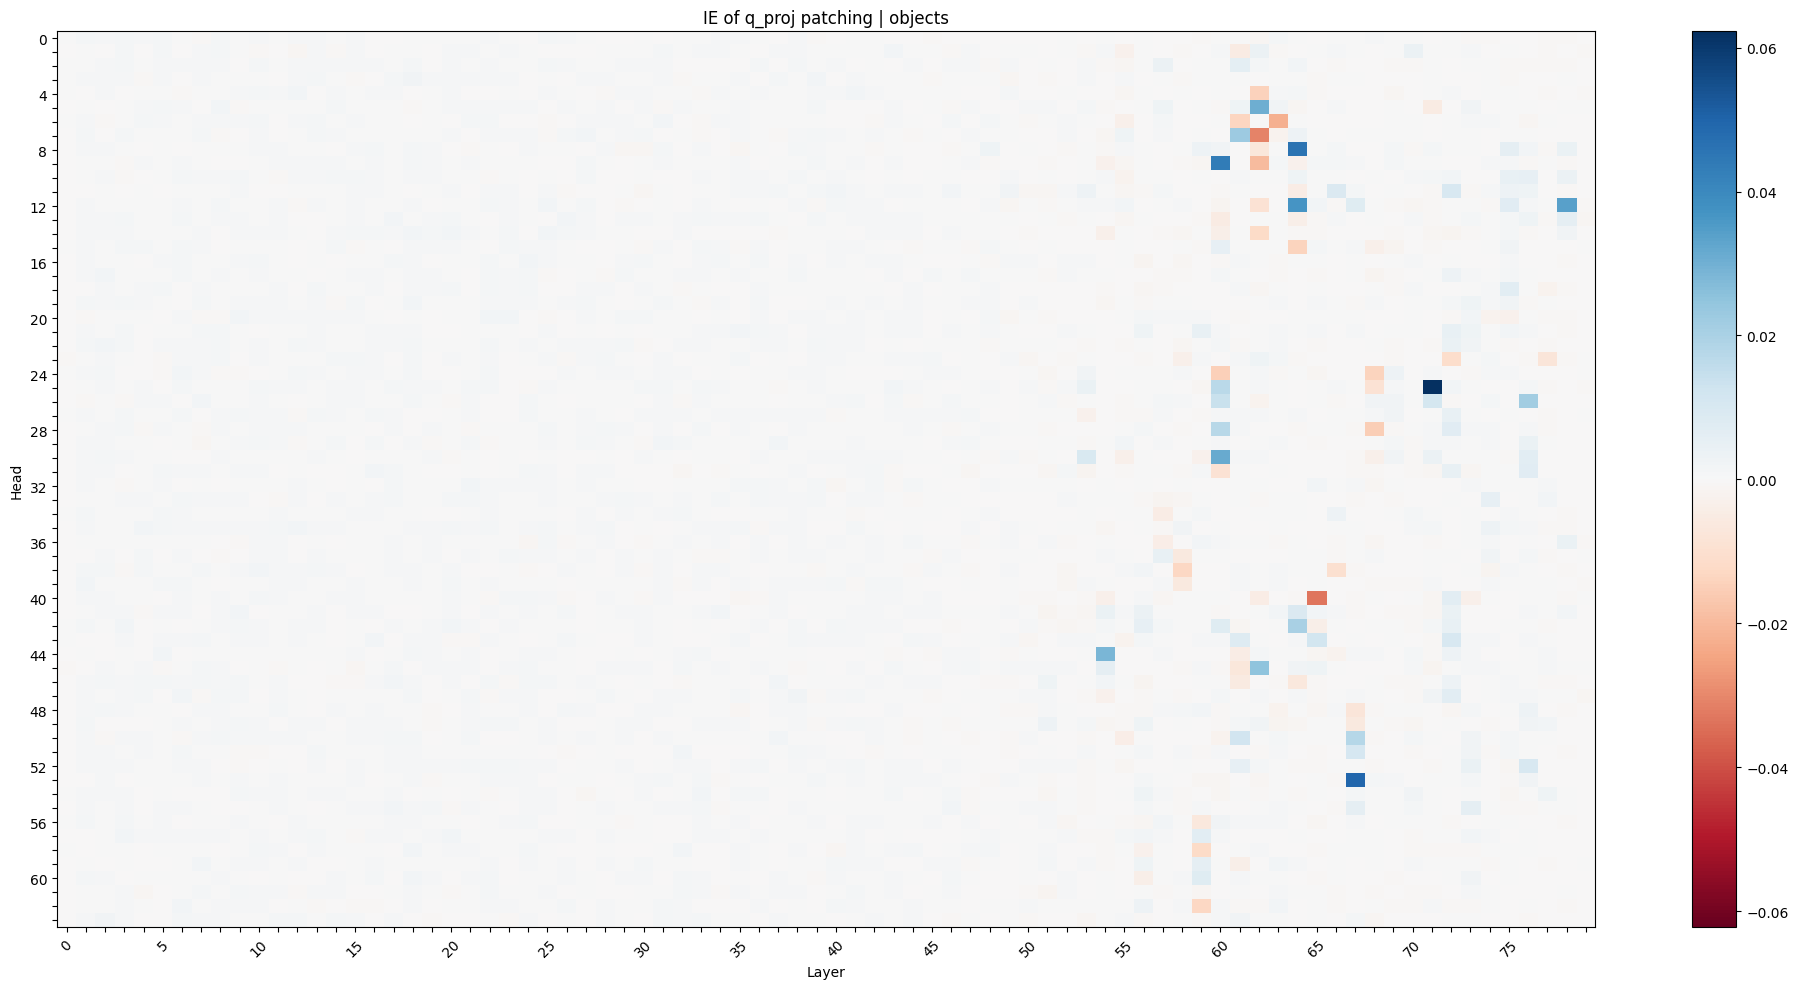

Layer 71, Head 25: 0.0623
Layer 67, Head 53: 0.0492
Layer 64, Head 8: 0.0460
Layer 60, Head 9: 0.0437
Layer 64, Head 12: 0.0369
Layer 78, Head 12: 0.0339
Layer 60, Head 30: 0.0315
Layer 62, Head 5: 0.0304
Layer 54, Head 44: 0.0283
Layer 62, Head 45: 0.0251
Layer 61, Head 7: 0.0225
Layer 76, Head 26: 0.0215
Layer 64, Head 42: 0.0203
Layer 67, Head 50: 0.0179
Layer 60, Head 28: 0.0173
2025-08-28 12:09:21 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7edde3d81910>


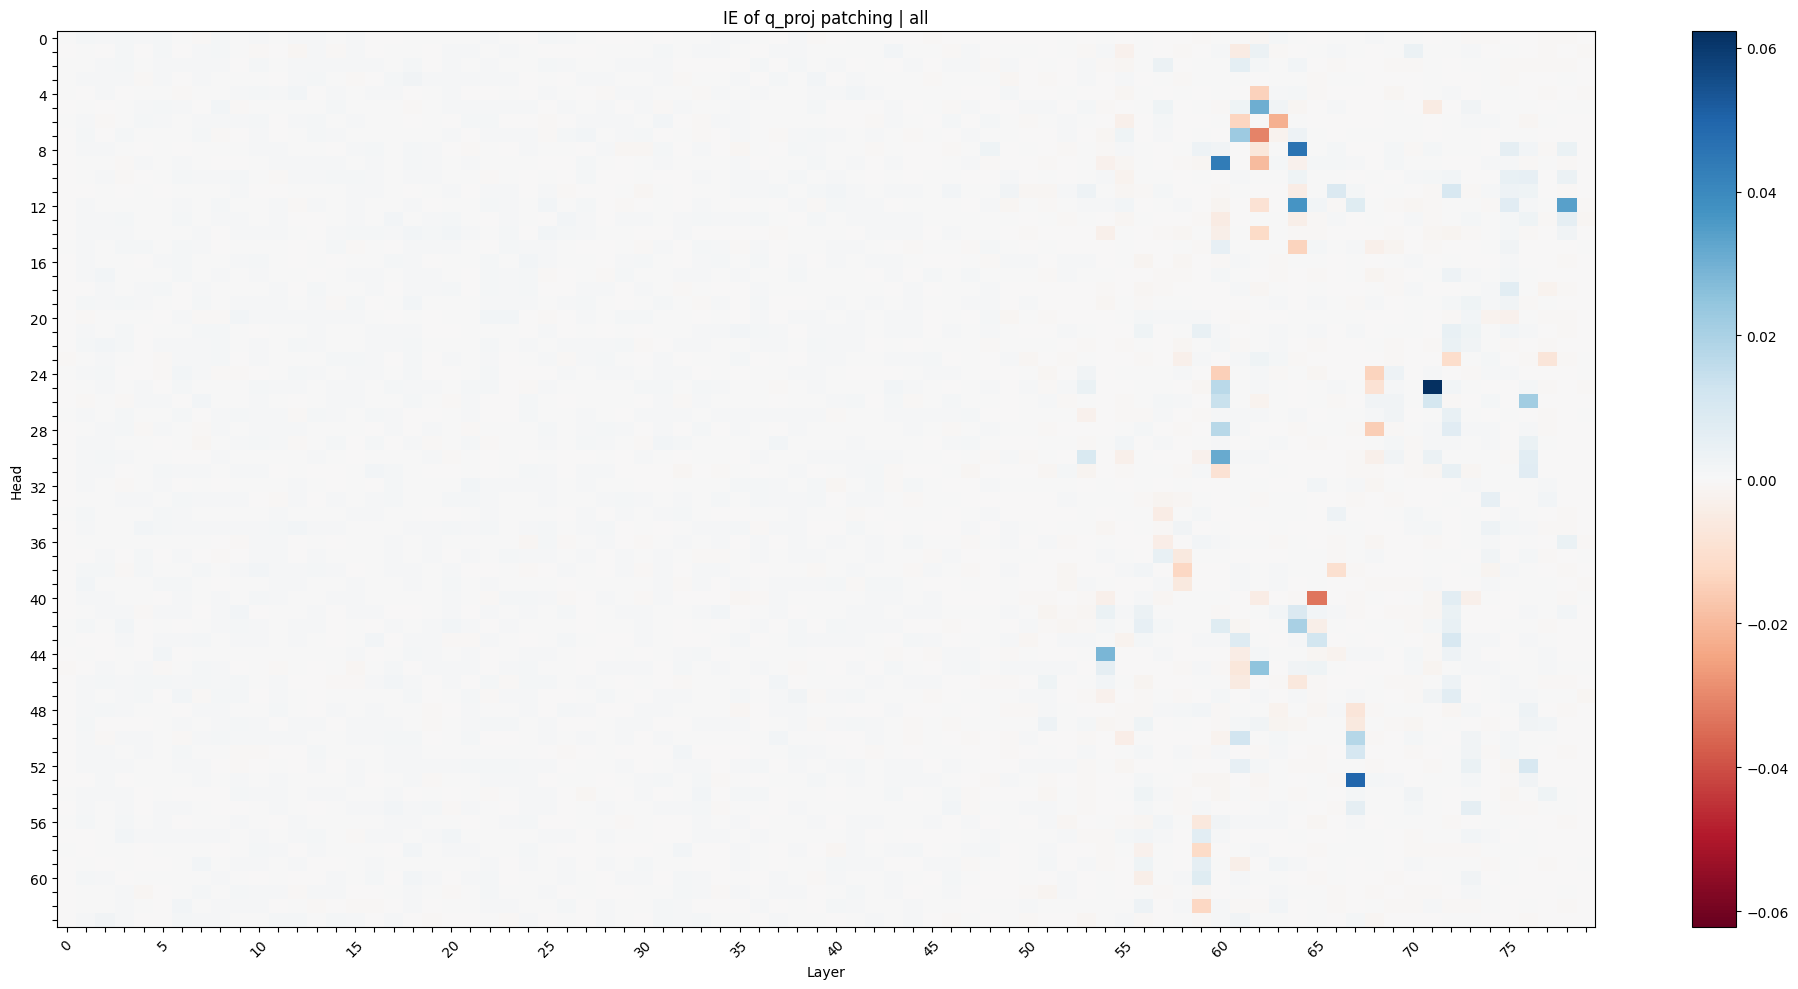

Layer 71, Head 25: 0.0623
Layer 67, Head 53: 0.0492
Layer 64, Head 8: 0.0460
Layer 60, Head 9: 0.0437
Layer 64, Head 12: 0.0369
Layer 78, Head 12: 0.0339
Layer 60, Head 30: 0.0315
Layer 62, Head 5: 0.0304
Layer 54, Head 44: 0.0283
Layer 62, Head 45: 0.0251
Layer 61, Head 7: 0.0225
Layer 76, Head 26: 0.0215
Layer 64, Head 42: 0.0203
Layer 67, Head 50: 0.0179
Layer 60, Head 28: 0.0173


In [57]:
from matplotlib import pyplot as plt

n_layer = mt.n_layer
n_heads = mt.config.num_attention_heads

category_wise_heads = {}
for category, categorywise_result in results_copy.items():
    indirect_effects = torch.zeros((n_layer, n_heads), dtype=torch.float32)
    for layer_idx in range(mt.n_layer):
        for head_idx in range(mt.config.num_attention_heads):
            indirect_effects[layer_idx, head_idx] = torch.mean(
                torch.tensor(
                    [
                        sample_result.head_effect(layer_idx, head_idx)
                        for sample_result in categorywise_result
                    ]
                )
            )

    plt.figure(figsize=(20, 10))
    scale = torch.max(torch.abs(indirect_effects))
    plt.imshow(
        indirect_effects.T.cpu().numpy(),
        cmap="RdBu",
        aspect="auto",
        vmin=-scale,
        vmax=scale,
    )
    plt.colorbar()
    # plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
    plt.title("IE of q_proj patching | " + category)
    plt.xlabel("Layer")
    plt.ylabel("Head")

    def get_ticks(ticks, skip=5):
        ret = []
        for i in ticks:
            if i % skip == 0:
                ret.append(str(i))
            else:
                ret.append("")
        return ret

    plt.xticks(
        ticks=range(n_layer),
        labels=get_ticks(range(n_layer)),
        rotation=45,
    )
    plt.yticks(
        ticks=range(n_head),
        labels=get_ticks(range(n_head), skip=4),
    )

    plt.tight_layout()
    plt.show()


    scores_per_head = []
    for layer_idx in range(n_layer):
        for head_idx in range(n_head):
            scores_per_head.append(
                (layer_idx, head_idx, indirect_effects[layer_idx, head_idx].item())
            )

    scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
    category_wise_heads[category] = scores_per_head
    for layer_idx, head_idx, score in scores_per_head[:15]:
        print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

with open("category_wise_heads.json", "w") as f:
    json.dump(category_wise_heads, f, indent=4)

#### Performing the Patch

In [32]:
from src.tokens import prepare_input
from src.functional import get_module_nnsight

# HEADS = [
#     (33, 45),
#     (33, 18),
#     (34, 1),
#     (34, 6),
#     (34, 7),
#     (35, 19),
#     (39, 40),
#     (42, 30),
#     (47, 18),
#     (52, 58),
# ]

# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:50]
# ]

# HEADS = heads_selected

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

# category_wise_heads["all"][len(HEADS) - 1]

In [28]:
from src.utils.typing import TokenizerOutput


@torch.inference_mode()
def cache_q_projections(
    mt: ModelandTokenizer,
    input: TokenizerOutput,
    query_locations: list[tuple[int, int, int]],  # (layer_idx, head_idx, query_idx)
    return_output: bool = False,
):
    layer_to_hq = {}
    for layer_idx, head_idx, query_idx in query_locations:
        if layer_idx not in layer_to_hq:
            layer_to_hq[layer_idx] = []
        layer_to_hq[layer_idx].append((head_idx, query_idx))

    q_projections = {}
    batch_size = input.input_ids.shape[0]
    seq_len = input.input_ids.shape[1]
    n_heads = mt.config.num_attention_heads
    head_dim = mt.n_embd // n_heads
    with mt.trace(input) as tracer:
        for layer_idx, query_locs in layer_to_hq.items():
            q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
            q_proj_module = get_module_nnsight(mt, q_proj_name)
            q_proj_out = q_proj_module.output.view(
                batch_size, seq_len, n_heads, head_dim
            ).transpose(1, 2)
            for head_idx, query_idx in query_locs:
                q_projections[(layer_idx, head_idx, query_idx)] = (
                    q_proj_out[:, head_idx, query_idx, :].squeeze().save()
                )

        if return_output:
            output = mt.output.save()

    if return_output:
        return q_projections, output
    return q_projections

In [51]:
query_indices = list(range(-3, 0))
query_locations = [
    (layer_idx, head_idx, query_idx)
    for layer_idx, head_idx in HEADS
    for query_idx in query_indices
]

cached_q_states = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    query_locations=query_locations,
)

# cached_q_states[(HEADS[0])].shape

In [52]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import interpret_logits

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

# attn_info = get_attention_matrices(
#     input=clean_tokenized,
#     mt=mt,
# )

# layer_idx, head_idx = 35, 19
# attn_matrix = attn_info.attention_matrices[layer_idx, head_idx].squeeze()
# visualize_attn_matrix(
#     attn_matrix=attn_matrix,
#     tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
#     q_index=-1,
# )

# interpret_logits(
#     tokenizer=mt,
#     logits=attn_info.logits,
#     interested_tokens=[clean_sample.obj_token_id, clean_sample.metadata["track_type_obj_token_id"]]
# )

attn_pattern = verify_head_patterns(
    prompt = clean_tokenized,
    options = clean_sample.options,
    pivot = clean_sample.subj,
    mt = mt,
    heads = HEADS,
    # heads = patching_heads,
    generate_full_answer=True,
)

attn_pattern["predictions"]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-13 18:15:22 src.experiments.utils DEBUG    Generated full answer: " Submarine.
Explanation: A submarine is a type of underwater vehicle that is used for various purposes, including military, scientific research, and exploration. It"
2025-08-13 18:15:22 src.experiments.utils DEBUG    Predictions: ['" Sub"[3804] (p=0.758, logit=21.375)', '" A"[362] (p=0.116, logit=19.500)', '" The"[578] (p=0.055, logit=18.750)', '" Among"[22395] (p=0.029, logit=18.125)', '" It"[1102] (p=0.008, logit=16.875)']
2025-08-13 18:15:22 src.experiments.utils INFO     Combined attention matrix for all heads


[PredictedToken(token=' Sub', prob=0.7578125, logit=21.375, token_id=3804, metadata=None),
 PredictedToken(token=' A', prob=0.11572265625, logit=19.5, token_id=362, metadata=None),
 PredictedToken(token=' The', prob=0.0546875, logit=18.75, token_id=578, metadata=None),
 PredictedToken(token=' Among', prob=0.029296875, logit=18.125, token_id=22395, metadata=None),
 PredictedToken(token=' It', prob=0.0084228515625, logit=16.875, token_id=1102, metadata=None)]

In [53]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import patch_with_nnsight, patch_with_baukit, PatchSpec

q_proj_patches = []
for (layer_idx, head_idx, query_idx), q_proj in cached_q_states.items():
    q_proj_patches.append(
        PatchSpec(
            location=(mt.attn_module_name_format.format(layer_idx) + ".q_proj", head_idx, query_idx),
            patch=q_proj
        )
    )

# patched_attn_info = get_attention_matrices(
#     input=clean_tokenized,
#     mt=mt,
#     patches=q_proj_patches,
#     patch_interface=patch_with_baukit
# )

# layer_idx, head_idx = 35, 19
# patched_attn_matrix = patched_attn_info.attention_matrices[layer_idx, head_idx].squeeze()
# visualize_attn_matrix(
#     attn_matrix=patched_attn_matrix,
#     tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
#     q_index=-1,
# )

# interpret_logits(
#     tokenizer=mt,
#     logits=patched_attn_info.logits,
#     interested_tokens=[clean_sample.obj_token_id, clean_sample.metadata["track_type_obj_token_id"]]
# )

patched_attn_pattern = verify_head_patterns(
    prompt = clean_tokenized,
    options = clean_sample.options,
    pivot = clean_sample.subj,
    mt = mt,
    heads = HEADS,
    # heads = patching_heads,
    query_patches=q_proj_patches,
    # generate_full_answer=True,
)

patched_attn_pattern["predictions"]

249 patches to ablate possible answer information from options
2025-08-13 18:15:29 src.experiments.utils DEBUG    Predictions: ['" Apple"[8325] (p=0.809, logit=21.625)', '" The"[578] (p=0.046, logit=18.750)', '" An"[1556] (p=0.040, logit=18.625)', '" Palm"[33578] (p=0.036, logit=18.500)', '" Among"[22395] (p=0.024, logit=18.125)']
2025-08-13 18:15:29 src.experiments.utils INFO     Combined attention matrix for all heads


[PredictedToken(token=' Apple', prob=0.80859375, logit=21.625, token_id=8325, metadata=None),
 PredictedToken(token=' The', prob=0.045654296875, logit=18.75, token_id=578, metadata=None),
 PredictedToken(token=' An', prob=0.040283203125, logit=18.625, token_id=1556, metadata=None),
 PredictedToken(token=' Palm', prob=0.03564453125, logit=18.5, token_id=33578, metadata=None),
 PredictedToken(token=' Among', prob=0.0244140625, logit=18.125, token_id=22395, metadata=None)]

### Search over layers and heads

In [23]:
clean_sample.metadata

{'track_category': 'fruit',
 'track_type_obj': 'Cherry',
 'track_type_obj_idx': 2,
 'track_type_obj_token_id': 44705,
 'tokenized': {'input_ids': tensor([[ 3798,    25, 74158,   850,    11,   809, 15938,    11, 44705,    11,
            6022,    11, 33292,    11, 21525,   624, 23085,  4221,  1493,  6171,
            9733,  3403,   374,   264,  7310,  5267, 16141,    25]],
         device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1]], device='cuda:0')}}

In [24]:
from scripts.patching_within_task import SelectionQprojPatchResult

In [25]:
from itertools import product
from src.functional import patch_with_baukit, interpret_logits
from src.selection.functional import cache_q_projections

all_heads = list(product(range(20, 30), range(mt.config.num_attention_heads)))
query_indices = {-3: -3, -2: -2, -1: -1}

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

interested_tokens = [
    patch_sample.ans_token_id,
    clean_sample.ans_token_id,
    clean_sample.metadata["track_type_obj_token_id"]
]


query_locations = [
    (layer_idx, head_idx, patch_query_idx)
    for layer_idx, head_idx in all_heads
    for patch_query_idx in query_indices.keys()
]

all_q_projections, patch_out = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    query_locations=query_locations,
    return_output=True,
)
logger.debug(len(all_q_projections))

patch_logits = patch_out.logits[:, -1, :].squeeze()
patch_precitions, patch_track = interpret_logits(
    tokenizer=mt,
    logits=patch_logits,
    interested_tokens=interested_tokens,
)

patch_precitions, patch_track

2025-08-26 17:44:23 __main__ DEBUG    1920


([PredictedToken(token=' Apple', prob=0.765625, logit=32.75, token_id=8162, metadata=None),
  PredictedToken(token=' The', prob=0.150390625, logit=31.125, token_id=576, metadata=None),
  PredictedToken(token=' Among', prob=0.055419921875, logit=30.125, token_id=21658, metadata=None),
  PredictedToken(token=' \n', prob=0.0230712890625, logit=29.25, token_id=715, metadata=None),
  PredictedToken(token=' \n\n', prob=0.0027618408203125, logit=27.125, token_id=4710, metadata=None)],
 OrderedDict([(8162,
               (1,
                PredictedToken(token=' Apple', prob=0.765625, logit=32.75, token_id=8162, metadata=None))),
              (44705,
               (326,
                PredictedToken(token=' Cherry', prob=6.6356733441352844e-09, logit=14.1875, token_id=44705, metadata=None))),
              (809,
               (938,
                PredictedToken(token=' Y', prob=8.440110832452774e-10, logit=12.125, token_id=809, metadata=None)))]))

In [26]:
clean_out = patch_with_baukit(
    mt=mt,
    inputs=clean_tokenized,
    patches=[],
)

base_logits = clean_out.logits[:, -1, :].squeeze()
base_predictions, base_track = interpret_logits(
    tokenizer=mt,
    logits=base_logits,
    interested_tokens=interested_tokens,
)
base_predictions, base_track

([PredictedToken(token=' Y', prob=0.88671875, logit=29.75, token_id=809, metadata=None),
  PredictedToken(token=' The', prob=0.07275390625, logit=27.25, token_id=576, metadata=None),
  PredictedToken(token=' Among', prob=0.0162353515625, logit=25.75, token_id=21658, metadata=None),
  PredictedToken(token=' \n', prob=0.00872802734375, logit=25.125, token_id=715, metadata=None),
  PredictedToken(token=' A', prob=0.0059814453125, logit=24.75, token_id=362, metadata=None)],
 OrderedDict([(809,
               (1,
                PredictedToken(token=' Y', prob=0.88671875, logit=29.75, token_id=809, metadata=None))),
              (44705,
               (829,
                PredictedToken(token=' Cherry', prob=7.683411240577698e-09, logit=11.1875, token_id=44705, metadata=None))),
              (8162,
               (4995,
                PredictedToken(token=' Apple', prob=5.566107574850321e-10, logit=8.5625, token_id=8162, metadata=None)))]))

In [27]:
from src.functional import PatchSpec
q_proj_patches = []
for (layer_idx, head_idx, patch_query_idx), q_proj in all_q_projections.items():
    q_proj_patches.append(
        PatchSpec(
            location=(
                mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                head_idx,
                query_indices[patch_query_idx],
            ),
            patch=q_proj,
        )
    )

int_out = patch_with_baukit(
    mt = mt,
    inputs = clean_tokenized,
    patches = q_proj_patches,
)

logits = int_out.logits[:, -1, :].squeeze()

interpret_logits(
    tokenizer=mt,
    logits=logits,
    interested_tokens=interested_tokens
)

([PredictedToken(token=' Y', prob=0.87109375, logit=29.75, token_id=809, metadata=None),
  PredictedToken(token=' The', prob=0.0810546875, logit=27.375, token_id=576, metadata=None),
  PredictedToken(token=' Among', prob=0.0205078125, logit=26.0, token_id=21658, metadata=None),
  PredictedToken(token=' \n', prob=0.00970458984375, logit=25.25, token_id=715, metadata=None),
  PredictedToken(token=' A', prob=0.005889892578125, logit=24.75, token_id=362, metadata=None)],
 OrderedDict([(809,
               (1,
                PredictedToken(token=' Y', prob=0.87109375, logit=29.75, token_id=809, metadata=None))),
              (44705,
               (786,
                PredictedToken(token=' Cherry', prob=9.720679372549057e-09, logit=11.4375, token_id=44705, metadata=None))),
              (8162,
               (4867,
                PredictedToken(token=' Apple', prob=6.621121428906918e-10, logit=8.75, token_id=8162, metadata=None)))]))

In [28]:
len(all_q_projections)

1920

In [29]:
list(all_q_projections.keys())[:5]

[(20, 0, -3), (20, 0, -2), (20, 0, -1), (20, 1, -3), (20, 1, -2)]

In [31]:
from tqdm.auto import tqdm
head_wise_patching_effects = {}

for (layer_idx, head_idx) in tqdm(all_heads):
    q_proj_patch = []
    for patch_tok_idx, clean_tok_idx in query_indices.items():
        q_proj_patch.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".q_proj", 
                    head_idx, 
                    query_indices[patch_tok_idx]
                ),
                patch=all_q_projections[(layer_idx, head_idx, patch_tok_idx)]
            )
        )
    out = patch_with_baukit(
        mt = mt,
        inputs = clean_tokenized,
        patches = q_proj_patch,
    )
    logits = out.logits[:, -1, :].squeeze()
    predictions, track = interpret_logits(
        tokenizer=mt,
        logits=logits,
        interested_tokens=interested_tokens
    )
    head_wise_patching_effects[(layer_idx, head_idx)] = track

  0%|          | 0/640 [00:00<?, ?it/s]

In [32]:
patching_results = SelectionQprojPatchResult(
    patch_sample=patch_sample,
    clean_sample=clean_sample,
    interested_tokens=interested_tokens,
    base_results=base_track,
    gold_results=patch_track,
    headwise_patching_effects=head_wise_patching_effects
)

In [33]:
patching_results.head_effect(layer_idx=25, head_idx=19)

0.002898550724637681

In [34]:
headwise_scores = [
    (
        layer_idx,
        head_idx,
        patching_results.head_effect(layer_idx, head_idx)
    )
    for layer_idx, head_idx in head_wise_patching_effects.keys()
]

headwise_scores = sorted(headwise_scores, key=lambda x: x[2], reverse=True)
patching_heads = []
for layer_idx, head_idx, score in headwise_scores[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")
    patching_heads.append((layer_idx, head_idx))

Layer 20, Head 4: 0.0058
Layer 20, Head 5: 0.0058
Layer 20, Head 49: 0.0058
Layer 21, Head 32: 0.0058
Layer 21, Head 36: 0.0058
Layer 21, Head 41: 0.0058
Layer 22, Head 24: 0.0058
Layer 22, Head 27: 0.0058
Layer 23, Head 3: 0.0058
Layer 23, Head 8: 0.0058
Layer 23, Head 38: 0.0058
Layer 23, Head 45: 0.0058
Layer 24, Head 14: 0.0058
Layer 24, Head 27: 0.0058
Layer 24, Head 33: 0.0058


In [39]:
patching_results.patch_sample.metadata.pop("tokenized")
patching_results.clean_sample.metadata.pop("tokenized")

{'input_ids': tensor([[ 3798,    25, 74158,   850,    11,   809, 15938,    11, 44705,    11,
           6022,    11, 33292,    11, 21525,   624, 23085,  4221,  1493,  6171,
           9733,  3403,   374,   264,  7310,  5267, 16141,    25]],
        device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1]], device='cuda:0')}

In [40]:
patching_results.delist_patching_effects()


In [41]:
with open("patching_results.json", "w") as f:
    json.dump(patching_results.to_dict(), f, indent=4)

In [42]:
with open("patching_results.json", "r") as f:
    loaded_results = json.load(f)

loaded_results["headwise_patching_effects"] = {
    (int(layer_idx.split("_<>_")[0]), int(layer_idx.split("_<>_")[1])): effect
    for layer_idx, effect in loaded_results["headwise_patching_effects"].items()
}

In [43]:
loaded_results["headwise_patching_effects"].keys()

dict_keys([(20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (20, 8), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (20, 16), (20, 17), (20, 18), (20, 19), (20, 20), (20, 21), (20, 22), (20, 23), (20, 24), (20, 25), (20, 26), (20, 27), (20, 28), (20, 29), (20, 30), (20, 31), (20, 32), (20, 33), (20, 34), (20, 35), (20, 36), (20, 37), (20, 38), (20, 39), (20, 40), (20, 41), (20, 42), (20, 43), (20, 44), (20, 45), (20, 46), (20, 47), (20, 48), (20, 49), (20, 50), (20, 51), (20, 52), (20, 53), (20, 54), (20, 55), (20, 56), (20, 57), (20, 58), (20, 59), (20, 60), (20, 61), (20, 62), (20, 63), (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), (21, 13), (21, 14), (21, 15), (21, 16), (21, 17), (21, 18), (21, 19), (21, 20), (21, 21), (21, 22), (21, 23), (21, 24), (21, 25), (21, 26), (21, 27), (21, 28), (21, 29), (21, 30), (21, 31), (21, 32), (21, 33), (21, 34), (21, 35), (21, 36),

In [45]:
patching_results_loaded = SelectionQprojPatchResult.from_dict(loaded_results)
patching_results_loaded.head_effect(layer_idx=25, head_idx=19)

0.002898550724637681

In [ ]:
mt.config.num_attention_heads

64

## Optimization to select heads to patch

In [126]:
from src.functional import free_gpu_cache
free_gpu_cache()

#################################################################################
train_limit = 512
# prompt_template_idx = 1
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

train_set = []
while len(train_set) < train_limit:
    patch, clean = get_counterfactual_samples_within_task(
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        distinct_options=True,
        n_distractors=N_DISTRACTORS,
    )
    train_set.append((clean, patch))

2025-08-28 15:41:23 __main__ INFO     Patch category: bathroom item, subject: Towel, object: Bathtub
2025-08-28 15:41:23 __main__ INFO     Clean category: furniture, subject: Bed, object: Table
2025-08-28 15:41:23 __main__ INFO     patch_must_have_options=['Bathtub', 'Bookshelf']
2025-08-28 15:41:23 __main__ INFO     clean_must_have_options=['Table', 'Soap']
2025-08-28 15:41:23 __main__ INFO     clean_type_obj='Bookshelf'
2025-08-28 15:41:23 __main__ INFO     patch_type_obj='Soap'
2025-08-28 15:41:23 __main__ INFO     patch_obj_idx=2 | ['Scissors', 'Watermelon', 'Bathtub', 'Bookshelf', 'Theater', 'Air fryer']
2025-08-28 15:41:23 __main__ INFO     clean_obj_idx=0 | ['Table', 'Slow cooker', 'Birch', 'Soap', 'Factory', 'Watch']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-28 15:41:23 __main__ INFO     # Options: Scissors, Watermelon, Bathtub, Bookshelf, Theater, Air fryer.
Which among these objects mentioned above is a bathroom item?
Answer:
2025-08-28 15:41:23 __main__ I

In [127]:
mt._model.zero_grad()
free_gpu_cache()
len(train_set)

512

In [30]:
from src.selection.optimization import get_optimal_head_mask
import numpy as np

free_gpu_cache()
optimal_mask, losses = get_optimal_head_mask(
    mt=mt,
    train_set=train_set,
    learning_rate=1e-2,
    n_epochs=20,
    lamb=2e-2,
    batch_size=16,
    query_indices=[-3, -2, -1],
    # black_list_heads=optimized_heads
)

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    # "selection/optimized_heads",
    "selection/optimized_backup_heads",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}.npz"
)

os.makedirs(os.path.dirname(optimized_path), exist_ok=True)

np.savez_compressed(
    optimized_path,
    **dict(
        optimal_mask=optimal_mask.to(torch.float32).numpy(),
        losses=np.array(losses, dtype=np.float32),
    ),
    allow_pickle=True,
)

2025-08-28 12:37:16 src.selection.optimization DEBUG    Training with hparams: {'learning_rate': 0.01, 'n_epochs': 20, 'lamb': 0.02, 'batch_size': 16}
2025-08-28 12:37:16 src.selection.optimization INFO     Caching q projections from patch samples...
2025-08-28 12:37:17 src.selection.optimization INFO     Caching completed > 1/32 batches.
2025-08-28 12:37:19 src.selection.optimization INFO     Caching completed > 2/32 batches.
2025-08-28 12:37:20 src.selection.optimization INFO     Caching completed > 3/32 batches.
2025-08-28 12:37:21 src.selection.optimization INFO     Caching completed > 4/32 batches.
2025-08-28 12:37:22 src.selection.optimization INFO     Caching completed > 5/32 batches.
2025-08-28 12:37:23 src.selection.optimization INFO     Caching completed > 6/32 batches.
2025-08-28 12:37:25 src.selection.optimization INFO     Caching completed > 7/32 batches.
2025-08-28 12:37:26 src.selection.optimization INFO     Caching completed > 8/32 batches.
2025-08-28 12:37:27 src.selec

In [31]:
mt.config.num_key_value_heads

8

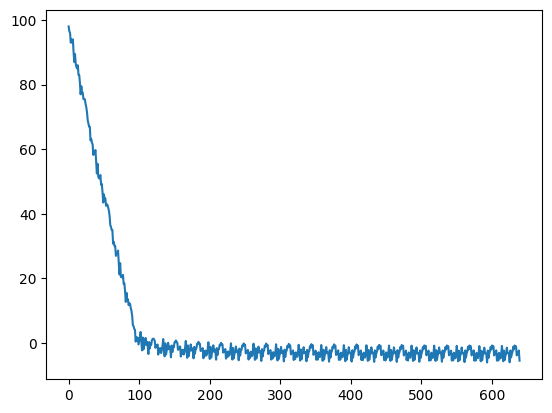

In [32]:
from matplotlib import pyplot as plt

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    # "selection/optimized_heads",
    "selection/optimized_backup_heads",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])

63


(False, False)

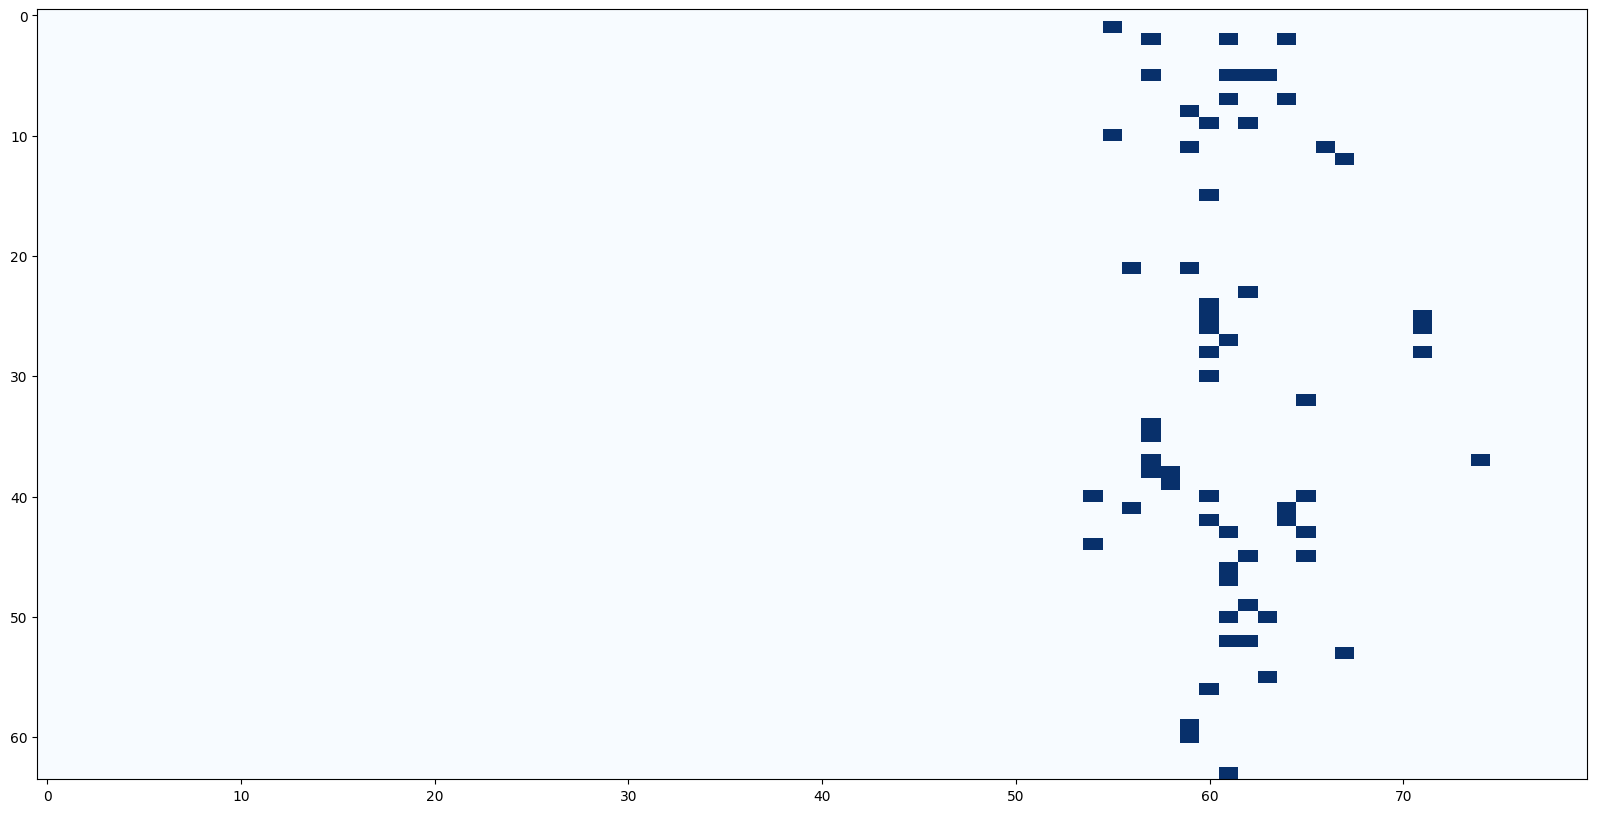

In [36]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
# optimal_head_mask[50:, :] = 0.0
optimal_head_mask[75:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

optimized_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).to(dtype=torch.int).tolist()
optimized_heads = [
    (layer_idx, head_idx) for layer_idx, head_idx in optimized_heads
]
print(len(optimized_heads))

HEADS = optimized_heads

(35, 19) in HEADS, (35, 19) in optimized_heads

In [37]:
len(optimized_heads)

63

## Validation of the patching effect

In [38]:
from src.functional import free_gpu_cache
free_gpu_cache()
validation_set = []
validation_limit = 256

while len(validation_set) < validation_limit:
    patch, clean = get_counterfactual_samples_within_task(
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        distinct_options=True,
        n_distractors=N_DISTRACTORS,
    )
    validation_set.append((clean, patch))

2025-08-28 14:05:30 __main__ INFO     Patch category: jewelry, subject: Ring, object: Brooch
2025-08-28 14:05:30 __main__ INFO     Clean category: tree, subject: Bamboo, object: Pine
2025-08-28 14:05:30 __main__ INFO     patch_must_have_options=['Brooch', 'Hickory']
2025-08-28 14:05:30 __main__ INFO     clean_must_have_options=['Pine', 'Chain']
2025-08-28 14:05:30 __main__ INFO     clean_type_obj='Hickory'
2025-08-28 14:05:30 __main__ INFO     patch_type_obj='Chain'
2025-08-28 14:05:30 __main__ INFO     patch_obj_idx=5 | ['Dishwasher', 'Table', 'Bike', 'Socks', 'Hickory', 'Brooch']
2025-08-28 14:05:30 __main__ INFO     clean_obj_idx=1 | ['Chain', 'Pine', 'Broccoli', 'Scooter', 'Bear', 'Skirt']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-28 14:05:30 __main__ INFO     # Options: Dishwasher, Table, Bike, Socks, Hickory, Brooch.
Which among these objects mentioned above is a jewelry?
Answer:
2025-08-28 14:05:30 __main__ INFO     Ring | jewelry -> Brooch | pred=['" Bro"[59

In [39]:
len(validation_set)

256

In [23]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair


# clean, patch = copy.deepcopy(validation_set[18])
# clean.default_option_style="numbered"
# patch.default_option_style="numbered"
# clean, patch = train_set[18]

clean, patch = copy.deepcopy(clean_sample), copy.deepcopy(patch_sample)

# failed_case = failed_cases[27]
# clean = failed_case["clean_sample"]
# patch = failed_case["patch_sample"]

print(clean.prompt(), ">>", clean.obj)
print(patch.prompt(), ">>", patch.obj)

validation_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    # heads=sorted(HEADS, key=lambda x: (x[0], x[1])),
    # heads=optimized_heads,
    # heads = sorted(qwen_72_heads, key=lambda x: (x[0], x[1])),
    # heads=heads_selected + backup_heads,
    # heads = overlapping_heads,
    heads=[(62, 1)],
    # query_indices={-3: -3, -2: -2, -1: -1},
    query_indices={-idx: -idx for idx in range(1, 20)},
    verify_head_behavior_on=-1,
    # ablate_possible_ans_info_from_options=True,
    amplification_scale=2.0
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": validation_result["clean_track"][clean_obj][0],
    "clean_logit": validation_result["clean_track"][clean_obj][1].logit,
    "target_rank": validation_result["clean_track"][target_obj][0],
    "target_logit": validation_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": validation_result["int_track"][clean_obj][0],
    "clean_logit": validation_result["int_track"][clean_obj][1].logit,
    "target_rank": validation_result["int_track"][target_obj][0],
    "target_logit": validation_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

# Options: Hairdryer, Clarinet, Submarine, Pendant, Cherry, Refrigerator.
Which among these objects mentioned above is a vehicle?
Answer: >> Submarine
# Options: Towel, Library, Coffee table, Tractor, Lion, Banana.
Which among these objects mentioned above is a fruit?
Answer: >> Banana
2025-08-28 15:13:58 src.selection.optimization INFO     Verifying head behavior...
2025-08-28 15:13:58 src.selection.optimization INFO     Clean Sample >> Ans: Submarine


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-28 15:14:04 src.selection.functional DEBUG    Generated full answer: " Submarine

A submarine is a watercraft capable of independent operation underwater. It is used for various purposes, including military operations, research, and exploration"
2025-08-28 15:14:04 src.selection.functional DEBUG    Predictions: ['" Sub"[3719] (p=0.734, logit=26.625)', '" The"[576] (p=0.145, logit=25.000)', '" Among"[21658] (p=0.053, logit=24.000)', '" A"[362] (p=0.017, logit=22.875)', '" \n"[715] (p=0.013, logit=22.625)']
2025-08-28 15:14:04 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-28 15:14:04 src.selection.optimization INFO     Patch Sample >> Ans: Banana
0 patches to ablate possible answer information from options


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-08-28 15:14:10 src.selection.functional DEBUG    Generated full answer: " Banana.

That's correct! Among the options provided—Towel, Library, Coffee table, Tractor, Lion, and Banana—the only fruit is"
2025-08-28 15:14:10 src.selection.functional DEBUG    Predictions: ['" Banana"[75824] (p=0.797, logit=26.750)', '" The"[576] (p=0.108, logit=24.750)', '" Among"[21658] (p=0.045, logit=23.875)', '" \n"[715] (p=0.017, logit=22.875)', '" A"[362] (p=0.009, logit=22.250)']
2025-08-28 15:14:10 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-28 15:14:10 src.selection.optimization INFO     Caching the query states for the 1 heads
2025-08-28 15:14:10 src.selection.optimization INFO     patch_prediction=['" Banana"[75824] (p=0.797, logit=26.750)', '" The"[576] (p=0.108, logit=24.750)', '" Among"[21658] (p=0.045, logit=23.875)', '" \n"[715] (p=0.017, logit=22.875)', '" A"[362] (p=0.009, logit=22.250)']
2025-08-28 15:14:10 src.selection.optimization INFO     clean run
2025-08-28 15:14:10 src.selection.optimization INFO     clean_prediction=['" Sub"[3719] (p=0.734, logit=26.625)', '" The"[576] (p=0.145, logit=25.000)', '" Among"[21658] (p=0.053, logit=24.000)', '" A"[362] (p=0.017, logit=22.875)', '" \n"[715] (p=0.013, logit=22.625)']
2025-08-28 15:14:10 src.selection.optimization INFO     clean_track=OrderedDict([(3719, (1, PredictedToken(token=' Sub', prob=0.734375, logit=26.625, token_id=3719, metadata=None))), (30081, (114, PredictedToken(token=' Clar', prob=4.798173904418945e-06, logit=14.6875, token_id=30081, metad

2025-08-28 15:14:11 src.selection.optimization INFO     int_prediction=['" Sub"[3719] (p=0.703, logit=25.625)', '" The"[576] (p=0.157, logit=24.125)', '" Among"[21658] (p=0.058, logit=23.125)', '" A"[362] (p=0.021, logit=22.125)', '" \n"[715] (p=0.017, logit=21.875)']
2025-08-28 15:14:11 src.selection.optimization INFO     int_track=OrderedDict([(3719, (1, PredictedToken(token=' Sub', prob=0.703125, logit=25.625, token_id=3719, metadata=None))), (30081, (90, PredictedToken(token=' Clar', prob=1.1742115020751953e-05, logit=14.625, token_id=30081, metadata=None))), (25697, (219, PredictedToken(token=' Hair', prob=1.2442469596862793e-06, logit=12.375, token_id=25697, metadata=None))), (74158, (402, PredictedToken(token=' Refriger', prob=3.129243850708008e-07, logit=11.0, token_id=74158, metadata=None))), (44705, (1730, PredictedToken(token=' Cherry', prob=2.270098775625229e-08, logit=8.375, token_id=44705, metadata=None))), (80401, (24656, PredictedToken(token=' Pendant', prob=7.785274647

In [62]:
prompt = """# Options: Lavender, Towel, Surfboard, Bench, Apple, Mosque. 
Which among these objects mentioned above is a sport equipment? 
Answer:"""
check_attn = verify_head_patterns(
    prompt=prompt,
    mt=mt,
    heads=sorted(qwen_72_heads, key=lambda x: (x[0], x[1]))
)

0 patches to ablate possible answer information from options
2025-08-28 14:33:53 src.selection.functional DEBUG    Predictions: ['" Surf"[64097] (p=0.766, logit=25.125)', '" The"[576] (p=0.117, logit=23.250)', '" Among"[21658] (p=0.049, logit=22.375)', '" \n"[715] (p=0.030, logit=21.875)', '" \n\n"[4710] (p=0.020, logit=21.500)']
2025-08-28 14:33:53 src.selection.functional INFO     Combined attention matrix for all heads


In [42]:
# from src.selection.functional import cache_q_projections, verify_head_patterns
# from typing import Literal
# from src.functional import PatchSpec, interpret_logits
# from src.hooking.llama_attention import LlamaAttentionPatcher
# import baukit
# import types


# def set_attn_implementation(mt, attn_implementation: Literal["sdpa", "eager"]):
#     mt.config._attn_implementation = attn_implementation
#     for layer_idx in range(mt.config.num_hidden_layers):
#         attn_block_name = mt.attn_module_name_format.format(layer_idx)
#         attn_block = baukit.get_module(mt._model, attn_block_name)
#         attn_block.config._attn_implementation = attn_implementation


# ##########################################################
# query_indices = [-3, -2, -1]
# heads = optimized_heads
# ##########################################################

# mt.reset_forward()
# set_attn_implementation(mt, "eager")

# clean_sample = failed_case["clean_sample"]
# patch_sample = failed_case["patch_sample"]

# clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
# patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

# verify_head_patterns(
#     prompt=patch_sample.prompt(),
#     tokenized_prompt=patch_tokenized,
#     pivot=patch_sample.subj,
#     options=patch_sample.options,
#     mt=mt,
#     heads=heads,
#     query_index=-1,
# )

# verify_head_patterns(
#     prompt=clean_sample.prompt(),
#     tokenized_prompt=clean_tokenized,
#     pivot=clean_sample.subj,
#     options=clean_sample.options,
#     mt=mt,
#     heads=heads,
#     query_index=-1,
# )

# query_locations = [
#     (layer_idx, head_idx, query_idx)
#     for layer_idx, head_idx in heads
#     for query_idx in query_indices
# ]

# cached_q_states, patch_output = cache_q_projections(
#     mt=mt,
#     input=patch_tokenized,
#     query_locations=query_locations,
#     return_output=True,
# )
# q_proj_patches = []
# for (layer_idx, head_idx, query_idx), q_proj in cached_q_states.items():
#     q_proj_patches.append(
#         PatchSpec(
#             location=(
#                 mt.attn_module_name_format.format(layer_idx) + ".q_proj",
#                 head_idx,
#                 query_idx,
#             ),
#             patch=q_proj,
#         )
#     )

# patch_logits = patch_output.logits[:, -1, :].squeeze()
# patch_predictions = interpret_logits(
#     tokenizer=mt,
#     logits=patch_logits,
# )
# logger.info(f"patch_prediction={[str(pred) for pred in patch_predictions]}")


# mt.reset_forward()
# set_attn_implementation(mt, "sdpa")

# layers_to_heads = {}
# for layer_idx, head_idx in heads:
#     if layer_idx not in layers_to_heads:
#         layers_to_heads[layer_idx] = []
#     layers_to_heads[layer_idx].append(head_idx)

# layers_to_q_patches = {}
# for (layer_idx, head_idx, query_idx), patch in cached_q_states.items():
#     if layer_idx not in layers_to_q_patches:
#         layers_to_q_patches[layer_idx] = []
#     layers_to_q_patches[layer_idx].append((head_idx, query_idx, patch))

# attention_patterns = {}
# head_contributions = {}
# for layer_idx, head_indices in layers_to_heads.items():
#     attn_block_name = mt.attn_module_name_format.format(layer_idx)
#     attn_block = baukit.get_module(mt._model, attn_block_name)

#     attention_patterns[layer_idx] = {}
#     head_contributions[layer_idx] = {}

#     attn_block.forward = types.MethodType(
#         LlamaAttentionPatcher(
#             block_name=attn_block_name,
#             save_attn_for=head_indices,
#             store_attn_matrices=attention_patterns[layer_idx],
#             store_head_contributions=head_contributions[layer_idx],
#             query_patches=layers_to_q_patches[layer_idx],
#             amplify_contributions=[
#                 (head_idx, q_idx, 2.0)
#                 for head_idx in head_indices
#                 for q_idx in query_indices
#             ],
#             # value_weighted=True,
#         ),
#         attn_block,
#     )


# output = mt._model(**clean_tokenized)
# int_logits = output.logits[:, -1, :].squeeze()
# int_pred = interpret_logits(
#     tokenizer=mt,
#     logits=int_logits,
# )

# logger.info(f"int_prediction={[str(pred) for pred in int_pred]}")

# mt.reset_forward()
# set_attn_implementation(mt, "eager")

In [43]:
# from src.selection.functional import visualize_attn_matrix

# attn_matrix = []
# for layer_idx in attention_patterns:
#     for head_idx in attention_patterns[layer_idx]:
#         attn_matrix.append(attention_patterns[layer_idx][head_idx].cpu())
# attn_matrix = torch.stack(attn_matrix).squeeze().mean(dim=0)

# visualize_attn_matrix(
#     attn_matrix = attn_matrix,
#     tokens = [mt.tokenizer.decode(t) for t in clean_tokenized["input_ids"][0]]
# )



In [44]:
from tqdm.auto import tqdm

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):
    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        # heads=backup_heads,
        # heads=optimized_heads + backup_heads,
        # heads = overlapping_heads,
        query_indices={-3: -3, -2: -2, -1: -1},
        verify_head_behavior_on=None,
        # amplification_scale=1.5
    )
    validation_results.append(result)
    print("=" * 80)

  0%|          | 0/256 [00:00<?, ?it/s]

2025-08-28 14:20:46 src.selection.optimization INFO     Caching the query states for the 63 heads


2025-08-28 14:20:46 src.selection.optimization INFO     patch_prediction=['" Bro"[5906] (p=0.762, logit=29.000)', '" The"[576] (p=0.132, logit=27.250)', '" A"[362] (p=0.043, logit=26.125)', '" Among"[21658] (p=0.026, logit=25.625)', '" To"[2014] (p=0.016, logit=25.125)']
2025-08-28 14:20:46 src.selection.optimization INFO     clean run
2025-08-28 14:20:46 src.selection.optimization INFO     clean_prediction=['" Pine"[41509] (p=0.820, logit=27.250)', '" The"[576] (p=0.098, logit=25.125)', '" Among"[21658] (p=0.052, logit=24.500)', '" To"[2014] (p=0.007, logit=22.500)', '" \n"[715] (p=0.006, logit=22.375)']
2025-08-28 14:20:46 src.selection.optimization INFO     clean_track=OrderedDict([(41509, (1, PredictedToken(token=' Pine', prob=0.8203125, logit=27.25, token_id=41509, metadata=None))), (5906, (20, PredictedToken(token=' Bro', prob=0.00012969970703125, logit=18.5, token_id=5906, metadata=None))), (28525, (36, PredictedToken(token=' Chain', prob=5.412101745605469e-05, logit=17.625, tok

In [45]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [46]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 6.4531 ± 8.0057
target_rank_delta: -980.8242 ± 1959.5065
clean_rank_after_intervention: 7.5586 ± 8.4083
target_rank_after_intervention: 99.2383 ± 266.2631


In [47]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -5.0642 ± 3.3531
target_logit_delta: 6.9495 ± 5.5642
clean_logit_after_intervention: 21.4573 ± 3.4285
target_logit_after_intervention: 18.5193 ± 5.4438


In [48]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.16796875

In [49]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)

Counterfactual patching accuracy: 0.3125 (80/256)


In [50]:
for failed_case in failed_cases[:20]:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", clean_sample.obj)

    print("-" * 100)
    print(
        "Track: ",
        clean_sample.metadata["track_type_obj"], " | Token"
        f"\"{mt.tokenizer.decode(clean_sample.metadata['track_type_obj_token_id'])}\"",
    )
    print("Clean:", clean_sample.obj, f"(Token: {mt.tokenizer.decode(clean_sample.ans_token_id)})")
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(
        f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}"
    )
    print("=" * 100)

Clean Sample:
# Options: Chain, Pine, Broccoli, Scooter, Bear, Skirt.
Which among these objects mentioned above is a tree?
Answer: >> Pine
----------------------------------------------------------------------------------------------------
Track:  Chain  | Token" Chain"
Clean: Pine (Token:  Pine)
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" Pine\"[41509] (p=0.820, logit=27.250)",
    "\" Bro\"[5906] (p=0.000, logit=18.500)",
    "\" Chain\"[28525] (p=0.000, logit=17.625)",
    "\" Bear\"[23985] (p=0.000, logit=14.375)",
    "\" Sk\"[4818] (p=0.000, logit=10.375)",
    "\" Sco\"[49059] (p=0.000, logit=9.250)"
]
Intervened Track: [
    "\" Pine\"[41509] (p=0.703, logit=27.500)",
    "\" Chain\"[28525] (p=0.000, logit=19.500)",
    "\" Bro\"[5906] (p=0.000, logit=18.750)",
    "\" Bear\"[23985] (p=0.000, logit=17.250)",
    "\" Sco\"[49059] (p=0.000, logit=10.750)",
    "\" Sk\"[4818] (p=0.000, logit=10.188)"
]

## Heads found with different tasks

Processing task: select_one
Optimal head mask shape for select_one: torch.Size([80, 64])
Processing task: select_order
Optimal head mask shape for select_order: torch.Size([80, 64])


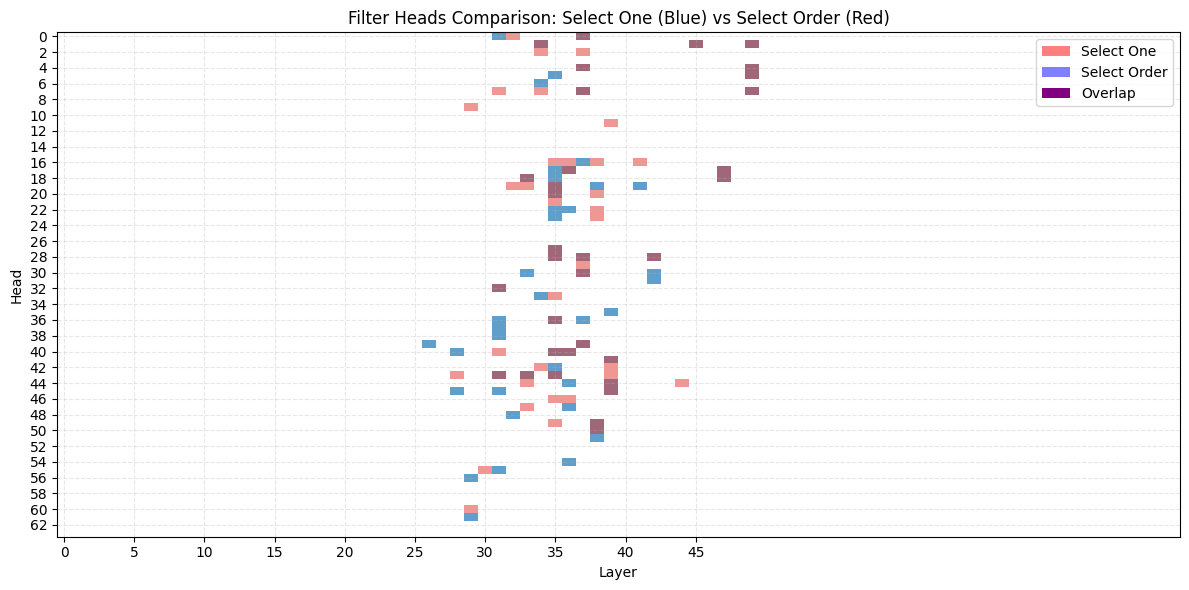

Total heads for select_one: 66
Total heads for select_order: 65
Overlapping heads: 33
Overlapping positions: [(31, 32), (31, 43), (33, 18), (33, 43), (34, 1), (35, 19), (35, 20), (35, 27), (35, 28), (35, 36), (35, 40), (35, 43), (36, 17), (36, 40), (37, 0), (37, 4), (37, 7), (37, 28), (37, 30), (37, 39), (38, 49), (38, 50), (39, 41), (39, 44), (39, 45), (42, 28), (45, 1), (47, 17), (47, 18), (49, 1), (49, 4), (49, 5), (49, 7)]


In [256]:
task_names = [
    "select_one", 
    "select_order"
]
heads = {task_name: [] for task_name in task_names}
colors = {
    "select_one": "Blues",
    "select_order": "Reds",
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create combined mask for overlapping heads
combined_mask = np.zeros((mt.config.num_attention_heads, mt.n_layer)) 

for i, task_name in enumerate(task_names):
    print("Processing task:", task_name)

    optimized_path = os.path.join(
        env_utils.DEFAULT_RESULTS_DIR,
        "selection/optimized_heads",
        mt.name.split("/")[-1],
        f"{task_name}.npz",
    )
    optimization_results = np.load(optimized_path, allow_pickle=True)
    optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(
        torch.float32
    )
    print(f"Optimal head mask shape for {task_name}: {optimal_head_mask.shape}")
    
    # Get head positions
    task_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
    task_heads = [
        (layer_idx, head_idx) for layer_idx, head_idx in task_heads if layer_idx < 50
    ]
    heads[task_name] = task_heads
    
    # Prepare mask for visualization
    optimal_head_mask = optimal_head_mask.round()
    optimal_head_mask[50:] = 0
    
    # Create a masked array to handle transparency properly
    mask_array = optimal_head_mask.T.numpy()
    masked_data = np.ma.masked_where(mask_array == 0, mask_array)
    
    # Plot with proper alpha blending
    im = ax.imshow(
        masked_data,
        cmap=colors[task_name],
        aspect="auto",
        vmin=0,
        vmax=1.5,
        alpha=0.8 if i == 0 else 0.5,  # Different alphas for better visibility
        interpolation='nearest'
    )
    
    # Track overlaps (optional)
    combined_mask += mask_array * (i + 1)

# Add labels and formatting
ax.set_xlabel("Layer")
ax.set_ylabel("Head")
ax.set_title("Filter Heads Comparison: Select One (Blue) vs Select Order (Red)")

# Add grid for clarity
ax.set_xticks(np.arange(0, 50, 5))
ax.set_yticks(np.arange(0, optimal_head_mask.shape[1], 2))
ax.grid(True, alpha=0.3, linestyle='--')

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', alpha=0.5, label='Select One'),
    Patch(facecolor='blue', alpha=0.5, label='Select Order'),
    Patch(facecolor='purple', alpha=1, label='Overlap')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Optional: Print overlap statistics
overlapping_heads = []
for task1_head in heads["select_one"]:
    if task1_head in heads["select_order"]:
        overlapping_heads.append(task1_head)

print(f"Total heads for select_one: {len(heads['select_one'])}")
print(f"Total heads for select_order: {len(heads['select_order'])}")
print(f"Overlapping heads: {len(overlapping_heads)}")
if overlapping_heads:
    print(f"Overlapping positions: {overlapping_heads}")

In [257]:
# find intersection of heads
overlapping_heads = set(heads[task_names[0]]) & set(heads[task_names[1]])
print(f"Intersection Heads: {len(overlapping_heads)}")

Intersection Heads: 33
